In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [5]:
new_channels = []
for i in range(32):
  new_channels.append(i)

In [6]:
def simple_2D_CNN(x):   
  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(32,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x = Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters=32, kernel_size=(7,7), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters=64, kernel_size=(9,9), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(256, activation='tanh')(x)
  x = Dropout(0.4)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (32, 256, 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 32, 1, 1)    0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['average_pooling2d[0][0]']      
                                                                                              

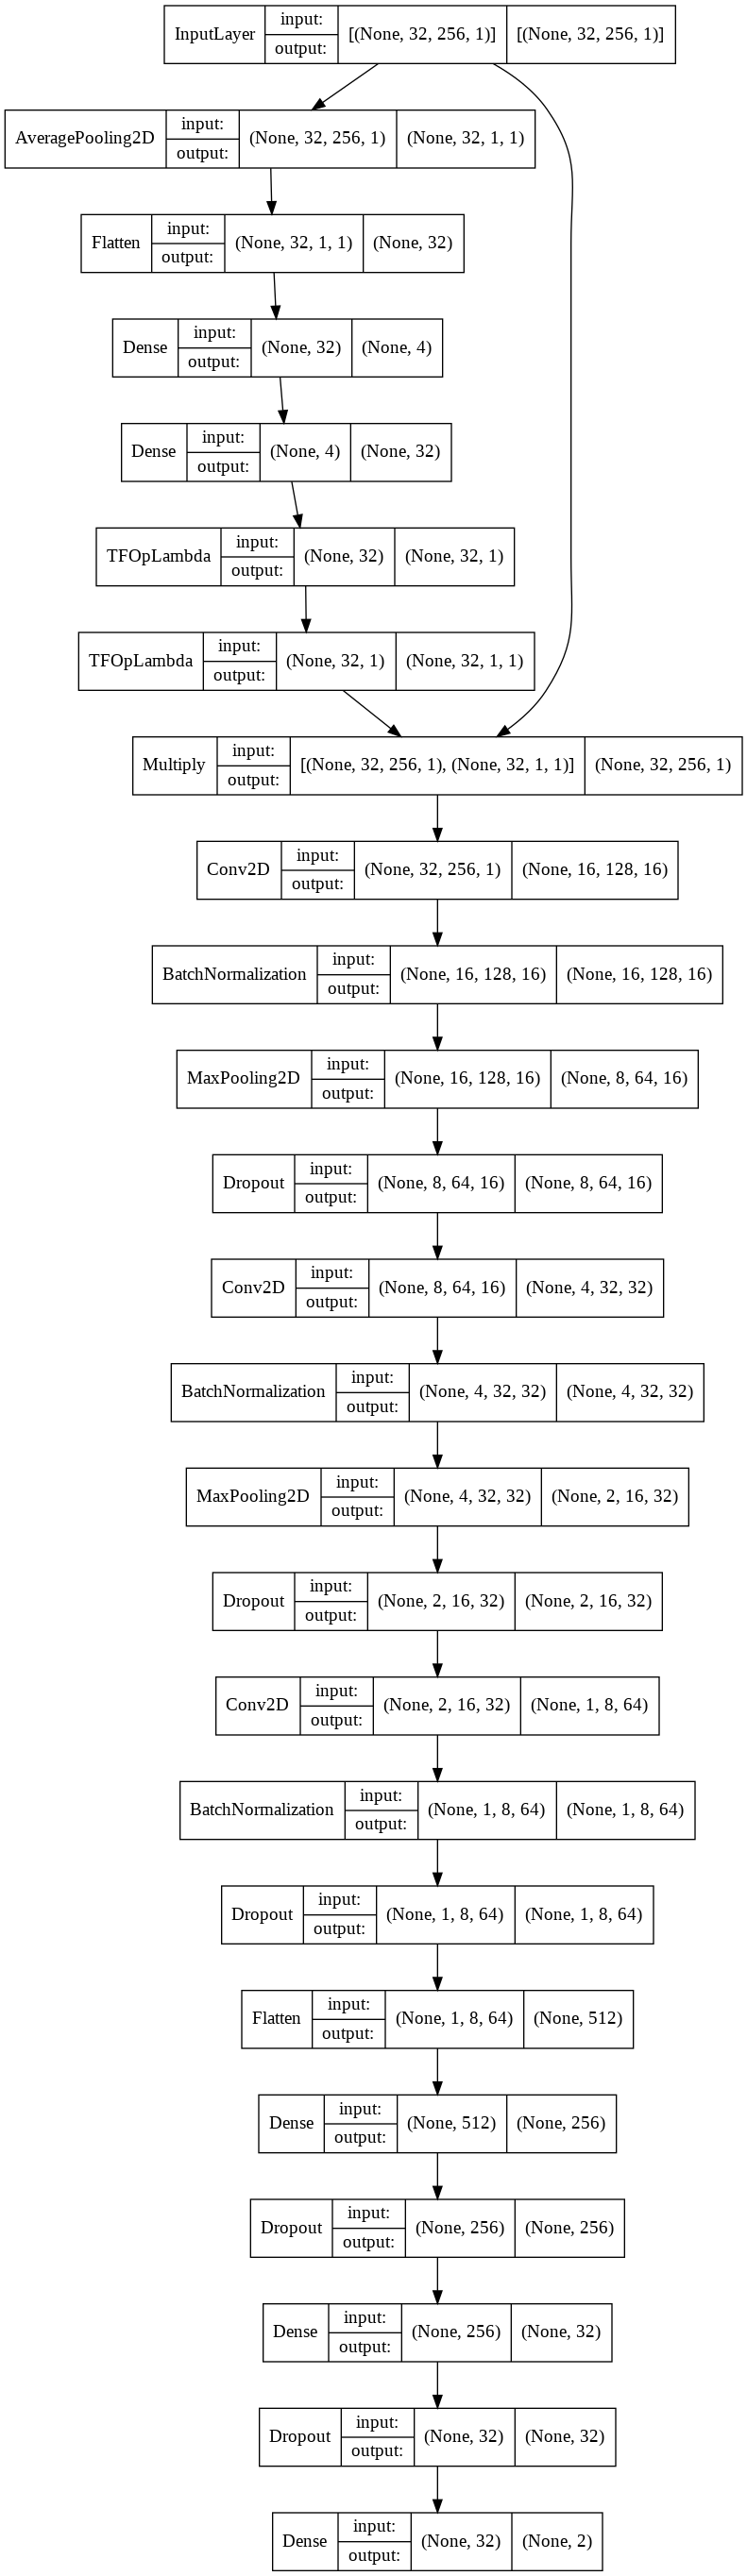

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [8]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

7161

In [9]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Subject 19**

In [10]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(19,20):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.19
(1200, 32, 256, 1)
(1200,) (510,) (690,)
(1200,) (390,) (810,)


0

# **Valence**

In [11]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 10s 25ms/step - loss: 1.0153 - accuracy: 0.5833 - val_loss: 0.6791 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8185 - accuracy: 0.5689 - val_loss: 0.6873 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7771 - accuracy: 0.5905 - val_loss: 0.6921 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7778 - accuracy: 0.6111 - val_loss: 0.6859 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.6420 - val_loss: 0.6856 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6790 - accuracy: 0.6327 - val_loss: 0.6995 - val_accuracy: 0.4537
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6572 - accuracy: 0.6481 - val_loss: 0.7109 - val_accuracy:

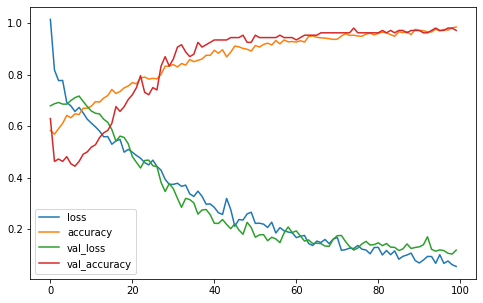

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0068 - accuracy: 0.5576 - val_loss: 0.6724 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8489 - accuracy: 0.5494 - val_loss: 0.6688 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7223 - accuracy: 0.5988 - val_loss: 0.6650 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7269 - accuracy: 0.6070 - val_loss: 0.6617 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7026 - accuracy: 0.6183 - val_loss: 0.6602 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6688 - accuracy: 0.6337 - val_loss: 0.6631 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6462 - accuracy: 0.6327 - val_loss: 0.6675 - val_accuracy: 

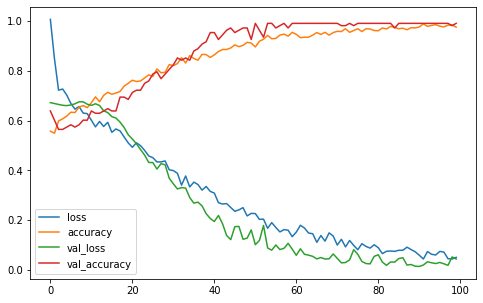

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9053 - accuracy: 0.5123 - val_loss: 0.6857 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7804 - accuracy: 0.5514 - val_loss: 0.6819 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7145 - accuracy: 0.5658 - val_loss: 0.6795 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6720 - accuracy: 0.6255 - val_loss: 0.6735 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6956 - accuracy: 0.5926 - val_loss: 0.6739 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6778 - accuracy: 0.6142 - val_loss: 0.6829 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6592 - accuracy: 0.6307 - val_loss: 0.7030 - val_accuracy: 

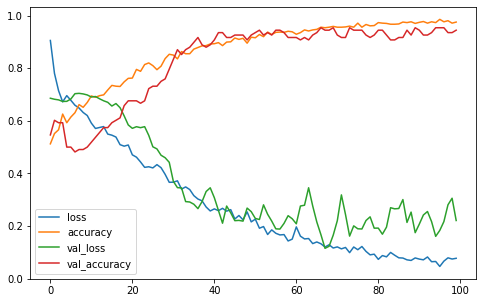

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 0.8818 - accuracy: 0.5360 - val_loss: 0.6753 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7730 - accuracy: 0.5782 - val_loss: 0.6592 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7207 - accuracy: 0.6039 - val_loss: 0.6492 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7124 - accuracy: 0.6101 - val_loss: 0.6440 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6856 - accuracy: 0.6307 - val_loss: 0.6382 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6720 - accuracy: 0.6348 - val_loss: 0.6300 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6601 - accuracy: 0.6399 - val_loss: 0.6172 - val_accuracy: 

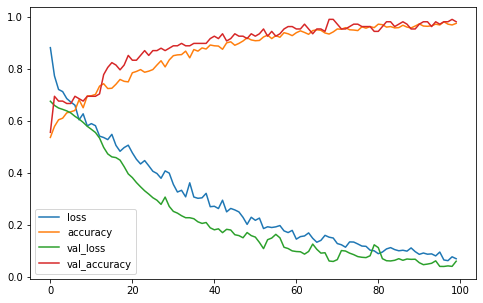

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8890 - accuracy: 0.5669 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7402 - accuracy: 0.5710 - val_loss: 0.6897 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7154 - accuracy: 0.5504 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6744 - accuracy: 0.5988 - val_loss: 0.6820 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6863 - accuracy: 0.5833 - val_loss: 0.6764 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6791 - accuracy: 0.6008 - val_loss: 0.6731 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6516 - accuracy: 0.6337 - val_loss: 0.6728 - val_accuracy: 

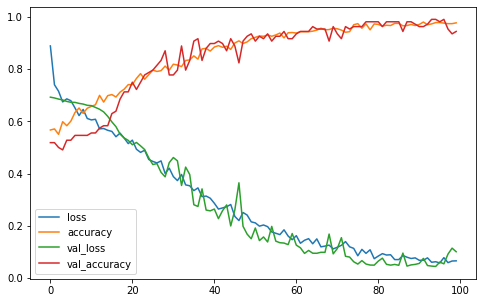

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8387 - accuracy: 0.5350 - val_loss: 0.6797 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7754 - accuracy: 0.5525 - val_loss: 0.6731 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7455 - accuracy: 0.5916 - val_loss: 0.6690 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6897 - accuracy: 0.5885 - val_loss: 0.6683 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6690 - accuracy: 0.6245 - val_loss: 0.6770 - val_accuracy: 0.4722
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6608 - accuracy: 0.6193 - val_loss: 0.6846 - val_accuracy: 0.4537
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6562 - accuracy: 0.5998 - val_loss: 0.6823 - val_accuracy

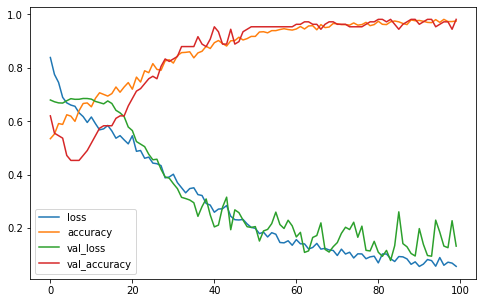

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8977 - accuracy: 0.5000 - val_loss: 0.6814 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8094 - accuracy: 0.5288 - val_loss: 0.6654 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7217 - accuracy: 0.5792 - val_loss: 0.6550 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7204 - accuracy: 0.5802 - val_loss: 0.6498 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6910 - accuracy: 0.6132 - val_loss: 0.6489 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6726 - accuracy: 0.6317 - val_loss: 0.6422 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6395 - accuracy: 0.6543 - val_loss: 0.6354 - val_accuracy: 

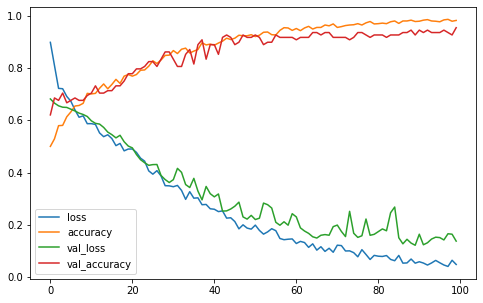

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9439 - accuracy: 0.5463 - val_loss: 0.6758 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8961 - accuracy: 0.5432 - val_loss: 0.6720 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7696 - accuracy: 0.5833 - val_loss: 0.6741 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7621 - accuracy: 0.5844 - val_loss: 0.6757 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6984 - accuracy: 0.6276 - val_loss: 0.6787 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7324 - accuracy: 0.6060 - val_loss: 0.6901 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6894 - accuracy: 0.5957 - val_loss: 0.6950 - val_accuracy: 

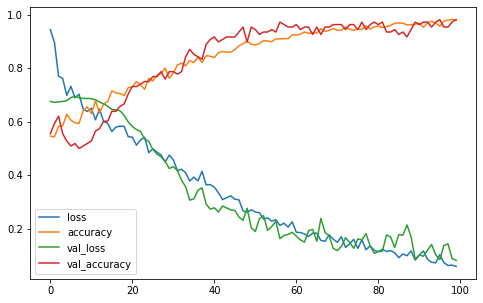

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9159 - accuracy: 0.5257 - val_loss: 0.6847 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7620 - accuracy: 0.5669 - val_loss: 0.6830 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7617 - accuracy: 0.5885 - val_loss: 0.6730 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7096 - accuracy: 0.5947 - val_loss: 0.6597 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6993 - accuracy: 0.6152 - val_loss: 0.6454 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6672 - accuracy: 0.6204 - val_loss: 0.6375 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.6091 - val_loss: 0.6269 - val_accuracy:

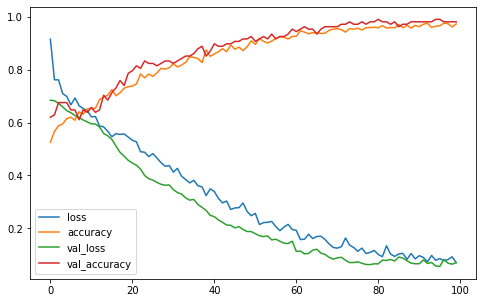

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9285 - accuracy: 0.5844 - val_loss: 0.6697 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8260 - accuracy: 0.5854 - val_loss: 0.6676 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7891 - accuracy: 0.6091 - val_loss: 0.6679 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7394 - accuracy: 0.6163 - val_loss: 0.6680 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7046 - accuracy: 0.6060 - val_loss: 0.6761 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6762 - accuracy: 0.6235 - val_loss: 0.6777 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6635 - accuracy: 0.6286 - val_loss: 0.6823 - val_accur

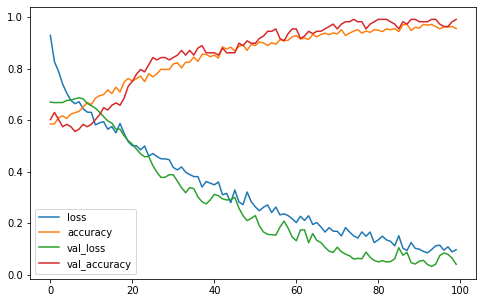

In [12]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9649999916553498
F1_Score  : 0.9648155583850035


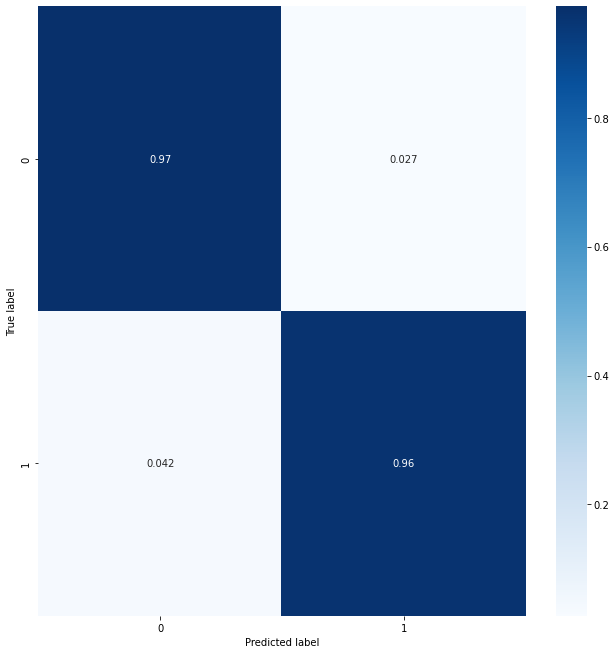

In [13]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [14]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0734 - accuracy: 0.4208 - val_loss: 0.6872 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8612 - accuracy: 0.5226 - val_loss: 0.6782 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8355 - accuracy: 0.5288 - val_loss: 0.6698 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7840 - accuracy: 0.5453 - val_loss: 0.6614 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7312 - accuracy: 0.5525 - val_loss: 0.6572 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7056 - accuracy: 0.5679 - val_loss: 0.6543 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6999 - accuracy: 0.5833 - val_loss: 0.6500 - val_accuracy: 

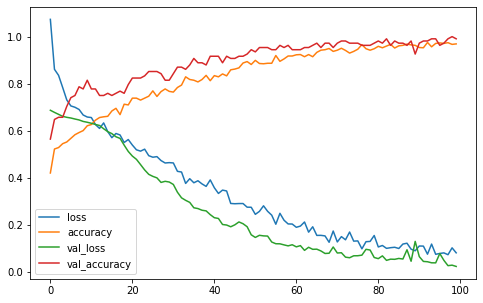

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0376 - accuracy: 0.5525 - val_loss: 0.7071 - val_accuracy: 0.3148
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8960 - accuracy: 0.5535 - val_loss: 0.7133 - val_accuracy: 0.3333
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8420 - accuracy: 0.5751 - val_loss: 0.6959 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7499 - accuracy: 0.5988 - val_loss: 0.6813 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7216 - accuracy: 0.6193 - val_loss: 0.6597 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7258 - accuracy: 0.6193 - val_loss: 0.6447 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7056 - accuracy: 0.6399 - val_loss: 0.6305 - val_accuracy: 

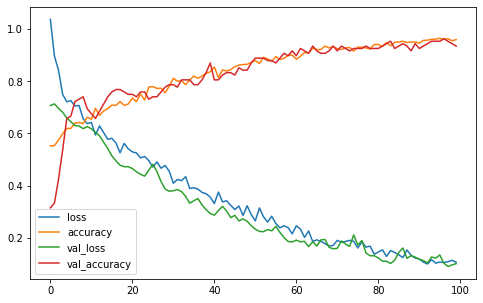

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0594 - accuracy: 0.4321 - val_loss: 0.6888 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8715 - accuracy: 0.5082 - val_loss: 0.6768 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8190 - accuracy: 0.5422 - val_loss: 0.6730 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7733 - accuracy: 0.5700 - val_loss: 0.6744 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7434 - accuracy: 0.5710 - val_loss: 0.6764 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7475 - accuracy: 0.5741 - val_loss: 0.6801 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6572 - accuracy: 0.6461 - val_loss: 0.6830 - val_accuracy: 

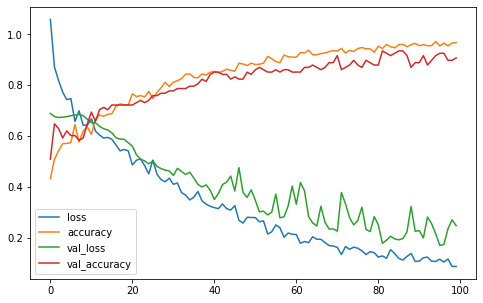

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.1350 - accuracy: 0.4156 - val_loss: 0.6726 - val_accuracy: 0.7315
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8677 - accuracy: 0.5432 - val_loss: 0.6569 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8230 - accuracy: 0.5566 - val_loss: 0.6469 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7970 - accuracy: 0.5638 - val_loss: 0.6383 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7216 - accuracy: 0.5967 - val_loss: 0.6289 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7106 - accuracy: 0.5916 - val_loss: 0.6223 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7359 - accuracy: 0.5535 - val_loss: 0.6264 - val_accuracy: 

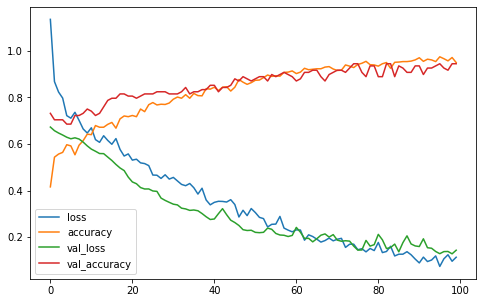

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8794 - accuracy: 0.5175 - val_loss: 0.6884 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8371 - accuracy: 0.5165 - val_loss: 0.6907 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7634 - accuracy: 0.5628 - val_loss: 0.6800 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7316 - accuracy: 0.5874 - val_loss: 0.6766 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7164 - accuracy: 0.5874 - val_loss: 0.6732 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7254 - accuracy: 0.5864 - val_loss: 0.6696 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6557 - accuracy: 0.6533 - val_loss: 0.6595 - val_accuracy: 

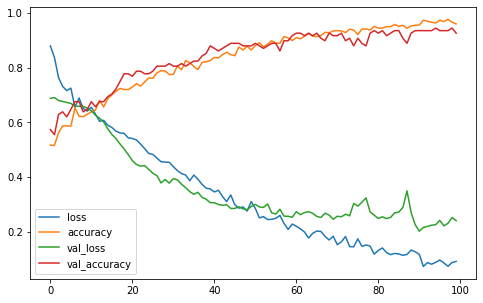

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8803 - accuracy: 0.6111 - val_loss: 0.6949 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7757 - accuracy: 0.5720 - val_loss: 0.7027 - val_accuracy: 0.3704
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7256 - accuracy: 0.6019 - val_loss: 0.7011 - val_accuracy: 0.4074
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6878 - accuracy: 0.6091 - val_loss: 0.6945 - val_accuracy: 0.4815
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6626 - accuracy: 0.6286 - val_loss: 0.6775 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6735 - accuracy: 0.6163 - val_loss: 0.6659 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6719 - accuracy: 0.6409 - val_loss: 0.6650 - val_accuracy: 

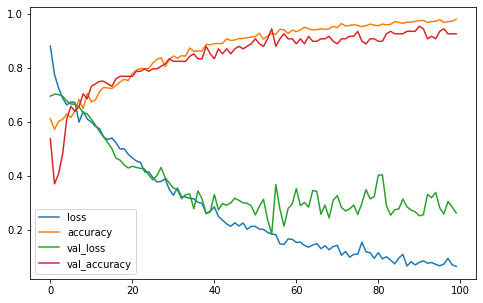

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8571 - accuracy: 0.5031 - val_loss: 0.6890 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7553 - accuracy: 0.5165 - val_loss: 0.6877 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7621 - accuracy: 0.5288 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7068 - accuracy: 0.5823 - val_loss: 0.7012 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7084 - accuracy: 0.5576 - val_loss: 0.7028 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6874 - accuracy: 0.6039 - val_loss: 0.7003 - val_accuracy: 0.4630
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6559 - accuracy: 0.6245 - val_loss: 0.6927 - val_accuracy

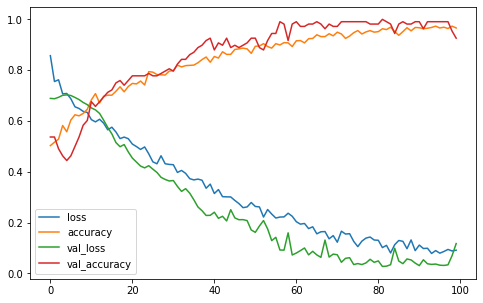

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 1.0136 - accuracy: 0.4475 - val_loss: 0.6978 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8826 - accuracy: 0.5463 - val_loss: 0.6816 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8215 - accuracy: 0.5761 - val_loss: 0.6605 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7832 - accuracy: 0.5669 - val_loss: 0.6438 - val_accuracy: 0.7778
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7529 - accuracy: 0.6060 - val_loss: 0.6338 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6847 - accuracy: 0.6307 - val_loss: 0.6259 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6866 - accuracy: 0.6049 - val_loss: 0.6172 - val_accuracy

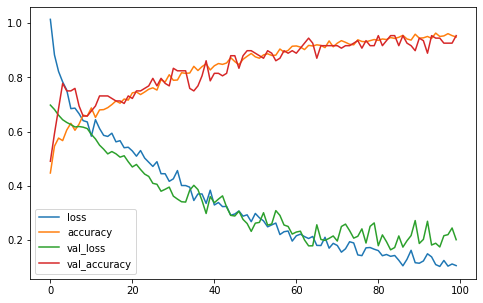

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0616 - accuracy: 0.4671 - val_loss: 0.6917 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9244 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8891 - accuracy: 0.5185 - val_loss: 0.6812 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8258 - accuracy: 0.5298 - val_loss: 0.6738 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7367 - accuracy: 0.5792 - val_loss: 0.6656 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7590 - accuracy: 0.5556 - val_loss: 0.6576 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7161 - accuracy: 0.5802 - val_loss: 0.6568 - val_accura

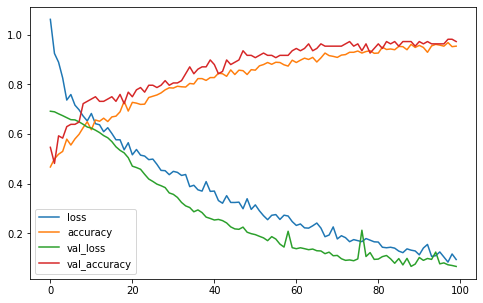

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9503 - accuracy: 0.6193 - val_loss: 0.6911 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8272 - accuracy: 0.5545 - val_loss: 0.7016 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7420 - accuracy: 0.5607 - val_loss: 0.7017 - val_accuracy: 0.3981
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7004 - accuracy: 0.5730 - val_loss: 0.6904 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6933 - accuracy: 0.5977 - val_loss: 0.6767 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6981 - accuracy: 0.5885 - val_loss: 0.6680 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.5957 - val_loss: 0.6637 - val_accura

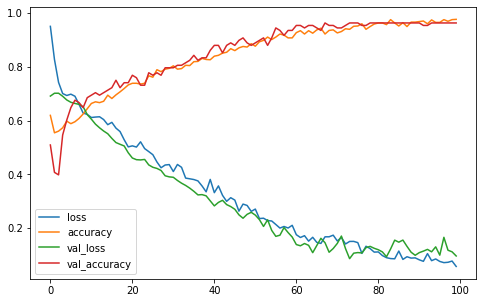

In [15]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9558333218097687
F1_Score  : 0.9448603993833217


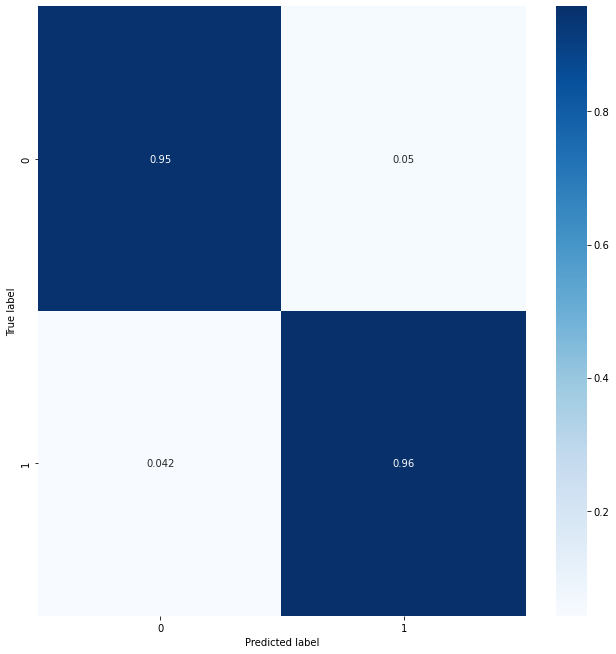

In [16]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 20**

In [17]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(20,21):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.20
(1200, 32, 256, 1)
(1200,) (510,) (690,)
(1200,) (270,) (930,)


3576

# **Valence**

In [18]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0237 - accuracy: 0.5144 - val_loss: 0.6815 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9063 - accuracy: 0.5401 - val_loss: 0.6941 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7713 - accuracy: 0.5905 - val_loss: 0.7346 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7179 - accuracy: 0.6039 - val_loss: 0.7618 - val_accuracy: 0.3889
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7447 - accuracy: 0.5782 - val_loss: 0.7939 - val_accuracy: 0.3796
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7200 - accuracy: 0.5895 - val_loss: 0.8279 - val_accuracy: 0.3704
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6971 - accuracy: 0.6080 - val_loss: 0.9022 - val_accuracy: 

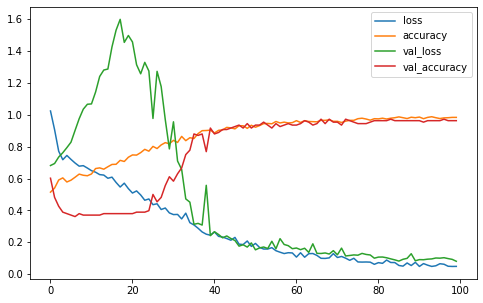

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9837 - accuracy: 0.5154 - val_loss: 0.6891 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8416 - accuracy: 0.5525 - val_loss: 0.6899 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8008 - accuracy: 0.5730 - val_loss: 0.6948 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7643 - accuracy: 0.5669 - val_loss: 0.7043 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7236 - accuracy: 0.6049 - val_loss: 0.7294 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6900 - accuracy: 0.6348 - val_loss: 0.7719 - val_accuracy: 0.5185
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6882 - accuracy: 0.6173 - val_loss: 0.8147 - val_accuracy:

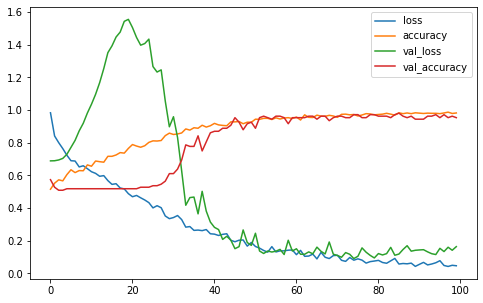

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 1.0174 - accuracy: 0.5123 - val_loss: 0.6886 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9163 - accuracy: 0.5226 - val_loss: 0.7030 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8863 - accuracy: 0.5484 - val_loss: 0.7217 - val_accuracy: 0.3981
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8391 - accuracy: 0.5442 - val_loss: 0.7392 - val_accuracy: 0.3981
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7520 - accuracy: 0.5874 - val_loss: 0.7648 - val_accuracy: 0.3981
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7845 - accuracy: 0.5679 - val_loss: 0.7996 - val_accuracy: 0.3981
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7701 - accuracy: 0.5617 - val_loss: 0.8125 - val_accuracy: 

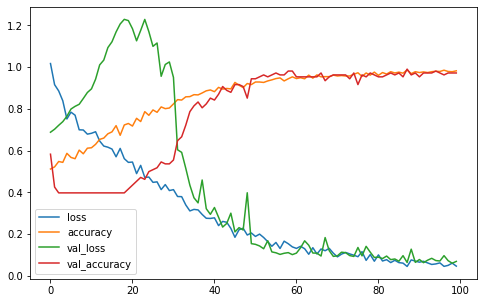

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9543 - accuracy: 0.5360 - val_loss: 0.6883 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9118 - accuracy: 0.5113 - val_loss: 0.6941 - val_accuracy: 0.4537
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8376 - accuracy: 0.5412 - val_loss: 0.7027 - val_accuracy: 0.3889
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.7223 - accuracy: 0.5792 - val_loss: 0.7115 - val_accuracy: 0.3889
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.7412 - accuracy: 0.5833 - val_loss: 0.7226 - val_accuracy: 0.3796
Epoch 6/100
16/16 [==============================] - 0s 17ms/step - loss: 0.6967 - accuracy: 0.6049 - val_loss: 0.7382 - val_accuracy: 0.3796
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.7221 - accuracy: 0.5957 - val_loss: 0.7537 - val_accura

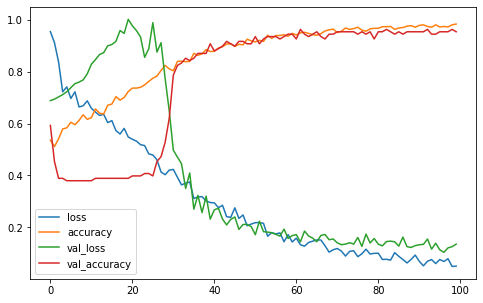

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9552 - accuracy: 0.5021 - val_loss: 0.6904 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8090 - accuracy: 0.5412 - val_loss: 0.6936 - val_accuracy: 0.4722
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7925 - accuracy: 0.5216 - val_loss: 0.6998 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7570 - accuracy: 0.5628 - val_loss: 0.7127 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7125 - accuracy: 0.5905 - val_loss: 0.7207 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.5874 - val_loss: 0.7291 - val_accuracy: 0.4444
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7189 - accuracy: 0.5679 - val_loss: 0.7494 - val_accuracy:

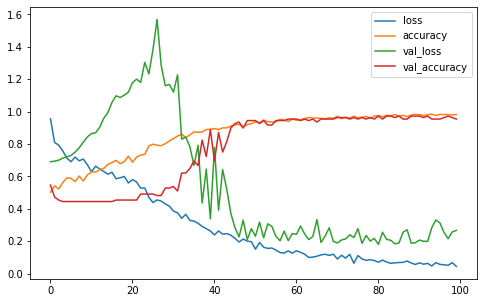

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.9680 - accuracy: 0.4383 - val_loss: 0.6900 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7640 - accuracy: 0.5216 - val_loss: 0.6858 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7413 - accuracy: 0.5422 - val_loss: 0.6845 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7106 - accuracy: 0.5638 - val_loss: 0.6857 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7032 - accuracy: 0.5556 - val_loss: 0.6878 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6800 - accuracy: 0.5864 - val_loss: 0.6948 - val_accuracy: 0.4352
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6781 - accuracy: 0.5628 - val_loss: 0.7072 - val_accuracy: 

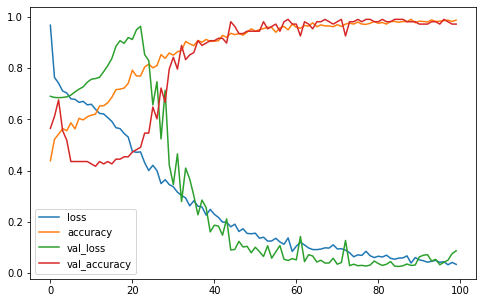

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9543 - accuracy: 0.5267 - val_loss: 0.6899 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9458 - accuracy: 0.5216 - val_loss: 0.6925 - val_accuracy: 0.4537
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7993 - accuracy: 0.5741 - val_loss: 0.6978 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7793 - accuracy: 0.5844 - val_loss: 0.7123 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7477 - accuracy: 0.5730 - val_loss: 0.7364 - val_accuracy: 0.4630
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7379 - accuracy: 0.5844 - val_loss: 0.7662 - val_accuracy: 0.4630
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7104 - accuracy: 0.5895 - val_loss: 0.8060 - val_accurac

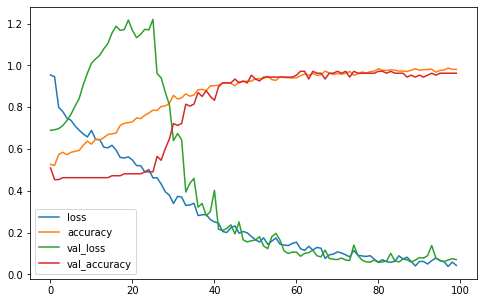

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0130 - accuracy: 0.5453 - val_loss: 0.6915 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8089 - accuracy: 0.5237 - val_loss: 0.6942 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7335 - accuracy: 0.5874 - val_loss: 0.6968 - val_accuracy: 0.4167
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7565 - accuracy: 0.5340 - val_loss: 0.6983 - val_accuracy: 0.4259
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7411 - accuracy: 0.5586 - val_loss: 0.7003 - val_accuracy: 0.4167
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7160 - accuracy: 0.5514 - val_loss: 0.7030 - val_accuracy: 0.4167
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6991 - accuracy: 0.5669 - val_loss: 0.7075 - val_accuracy:

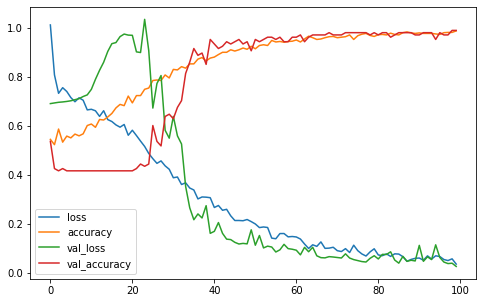

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0949 - accuracy: 0.4774 - val_loss: 0.6888 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9286 - accuracy: 0.5144 - val_loss: 0.6956 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7974 - accuracy: 0.5679 - val_loss: 0.7120 - val_accuracy: 0.4074
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7249 - accuracy: 0.5967 - val_loss: 0.7362 - val_accuracy: 0.4167
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7170 - accuracy: 0.5947 - val_loss: 0.7697 - val_accuracy: 0.4074
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7254 - accuracy: 0.5895 - val_loss: 0.8099 - val_accuracy: 0.4074
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7222 - accuracy: 0.5864 - val_loss: 0.8530 - val_accurac

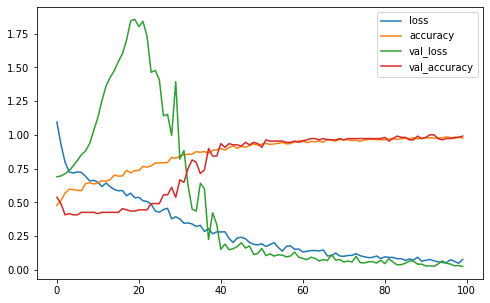

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9448 - accuracy: 0.5247 - val_loss: 0.6887 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8430 - accuracy: 0.5278 - val_loss: 0.6902 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8100 - accuracy: 0.5494 - val_loss: 0.6939 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7591 - accuracy: 0.5710 - val_loss: 0.6995 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7491 - accuracy: 0.5648 - val_loss: 0.7067 - val_accuracy: 0.4352
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7359 - accuracy: 0.5844 - val_loss: 0.7149 - val_accuracy: 0.4444
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6967 - accuracy: 0.6060 - val_loss: 0.7196 - val_accurac

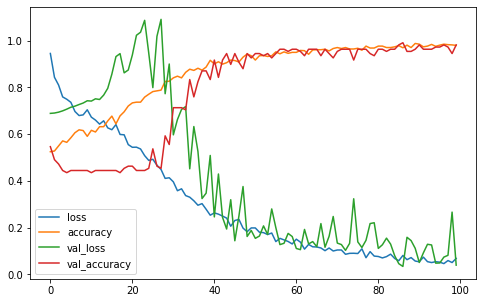

In [19]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9833333432674408
F1_Score  : 0.9831415741128307


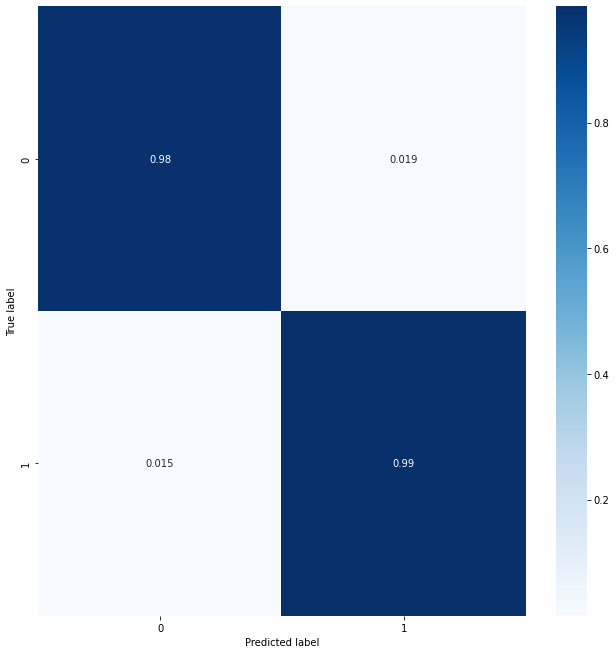

In [20]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [21]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9025 - accuracy: 0.4784 - val_loss: 0.6888 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8509 - accuracy: 0.5216 - val_loss: 0.6904 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7840 - accuracy: 0.5360 - val_loss: 0.6894 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7671 - accuracy: 0.5432 - val_loss: 0.6873 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7763 - accuracy: 0.5617 - val_loss: 0.6797 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6855 - accuracy: 0.6019 - val_loss: 0.6784 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7047 - accuracy: 0.6101 - val_loss: 0.6857 - val_accuracy: 

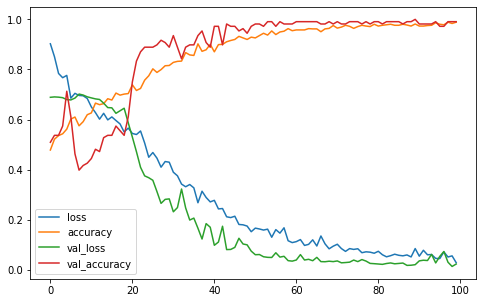

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8862 - accuracy: 0.4712 - val_loss: 0.6815 - val_accuracy: 0.7037
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8205 - accuracy: 0.5484 - val_loss: 0.6849 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7771 - accuracy: 0.5391 - val_loss: 0.6952 - val_accuracy: 0.4167
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7625 - accuracy: 0.5586 - val_loss: 0.7033 - val_accuracy: 0.3426
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7057 - accuracy: 0.5700 - val_loss: 0.7024 - val_accuracy: 0.3426
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7409 - accuracy: 0.5412 - val_loss: 0.7049 - val_accuracy: 0.3148
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7133 - accuracy: 0.5669 - val_loss: 0.7068 - val_accuracy:

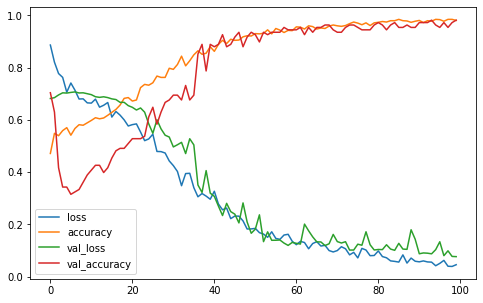

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0093 - accuracy: 0.6019 - val_loss: 0.7042 - val_accuracy: 0.3426
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8672 - accuracy: 0.5278 - val_loss: 0.7345 - val_accuracy: 0.2037
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8351 - accuracy: 0.5165 - val_loss: 0.7231 - val_accuracy: 0.2037
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7276 - accuracy: 0.5700 - val_loss: 0.7055 - val_accuracy: 0.4259
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7608 - accuracy: 0.5597 - val_loss: 0.6948 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7141 - accuracy: 0.5905 - val_loss: 0.6915 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7160 - accuracy: 0.5977 - val_loss: 0.6936 - val_accuracy: 

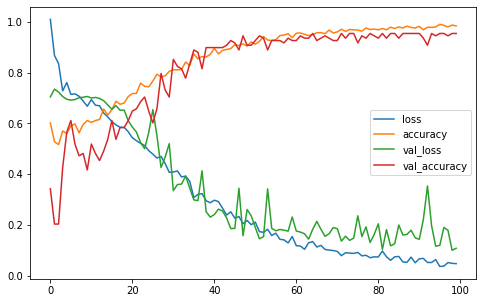

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9073 - accuracy: 0.5309 - val_loss: 0.7028 - val_accuracy: 0.2870
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7991 - accuracy: 0.5833 - val_loss: 0.7005 - val_accuracy: 0.3611
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8256 - accuracy: 0.5813 - val_loss: 0.7239 - val_accuracy: 0.2500
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7657 - accuracy: 0.5597 - val_loss: 0.7608 - val_accuracy: 0.2407
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7385 - accuracy: 0.5802 - val_loss: 0.7864 - val_accuracy: 0.2315
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7801 - accuracy: 0.5710 - val_loss: 0.7954 - val_accuracy: 0.2222
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7005 - accuracy: 0.5895 - val_loss: 0.8136 - val_accuracy: 

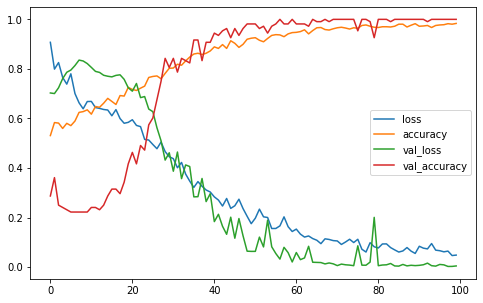

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9981 - accuracy: 0.5453 - val_loss: 0.6972 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8636 - accuracy: 0.5144 - val_loss: 0.7022 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8512 - accuracy: 0.5525 - val_loss: 0.6979 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7482 - accuracy: 0.6060 - val_loss: 0.6987 - val_accuracy: 0.4537
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7678 - accuracy: 0.5792 - val_loss: 0.7063 - val_accuracy: 0.3796
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7321 - accuracy: 0.5844 - val_loss: 0.7080 - val_accuracy: 0.3981
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7157 - accuracy: 0.5936 - val_loss: 0.7064 - val_accuracy: 

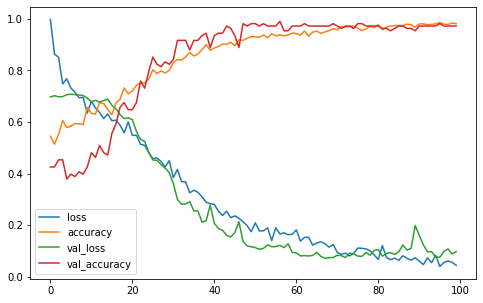

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9227 - accuracy: 0.4331 - val_loss: 0.6846 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8496 - accuracy: 0.4794 - val_loss: 0.6703 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7731 - accuracy: 0.5041 - val_loss: 0.6604 - val_accuracy: 0.8056
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7560 - accuracy: 0.5453 - val_loss: 0.6649 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7491 - accuracy: 0.5484 - val_loss: 0.6697 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6952 - accuracy: 0.5638 - val_loss: 0.6652 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5710 - val_loss: 0.6503 - val_accuracy: 

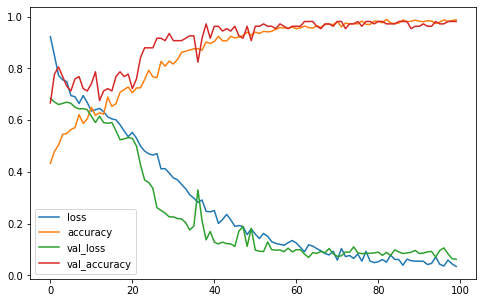

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9243 - accuracy: 0.5309 - val_loss: 0.6930 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9254 - accuracy: 0.5319 - val_loss: 0.7087 - val_accuracy: 0.3333
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8472 - accuracy: 0.5412 - val_loss: 0.7179 - val_accuracy: 0.2778
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8358 - accuracy: 0.5504 - val_loss: 0.7333 - val_accuracy: 0.2778
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8302 - accuracy: 0.5473 - val_loss: 0.7527 - val_accuracy: 0.2407
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7709 - accuracy: 0.5669 - val_loss: 0.7619 - val_accuracy: 0.2500
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7636 - accuracy: 0.5905 - val_loss: 0.7637 - val_accuracy:

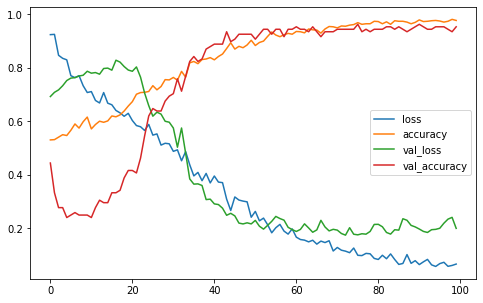

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9524 - accuracy: 0.4784 - val_loss: 0.6715 - val_accuracy: 0.7778
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.9114 - accuracy: 0.5206 - val_loss: 0.6802 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8071 - accuracy: 0.5432 - val_loss: 0.6899 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7394 - accuracy: 0.5504 - val_loss: 0.6888 - val_accuracy: 0.5463
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7205 - accuracy: 0.5916 - val_loss: 0.6897 - val_accuracy: 0.5463
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7402 - accuracy: 0.5556 - val_loss: 0.7064 - val_accuracy: 0.3796
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7280 - accuracy: 0.5967 - val_loss: 0.7281 - val_accurac

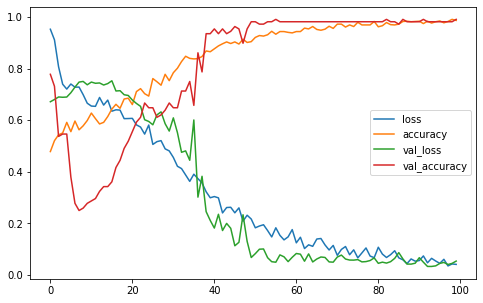

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9589 - accuracy: 0.4805 - val_loss: 0.6903 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8488 - accuracy: 0.5792 - val_loss: 0.7118 - val_accuracy: 0.3519
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7965 - accuracy: 0.5442 - val_loss: 0.7291 - val_accuracy: 0.3333
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7253 - accuracy: 0.6070 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7155 - accuracy: 0.6348 - val_loss: 0.7580 - val_accuracy: 0.3148
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7444 - accuracy: 0.5936 - val_loss: 0.7957 - val_accuracy: 0.3148
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6911 - accuracy: 0.5864 - val_loss: 0.8317 - val_accur

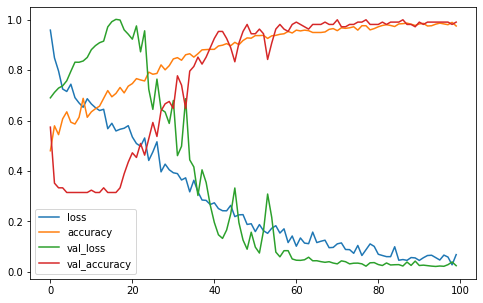

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0467 - accuracy: 0.4928 - val_loss: 0.6869 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9241 - accuracy: 0.4753 - val_loss: 0.6942 - val_accuracy: 0.4352
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8017 - accuracy: 0.4794 - val_loss: 0.7106 - val_accuracy: 0.3241
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7870 - accuracy: 0.5298 - val_loss: 0.7113 - val_accuracy: 0.3333
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7708 - accuracy: 0.5051 - val_loss: 0.7230 - val_accuracy: 0.2870
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7499 - accuracy: 0.5082 - val_loss: 0.7229 - val_accuracy: 0.2685
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7519 - accuracy: 0.5463 - val_loss: 0.7225 - val_accura

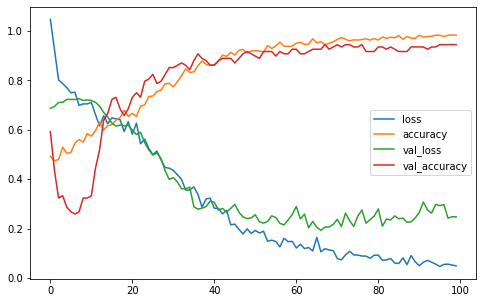

In [22]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9883333444595337
F1_Score  : 0.9729833261346643


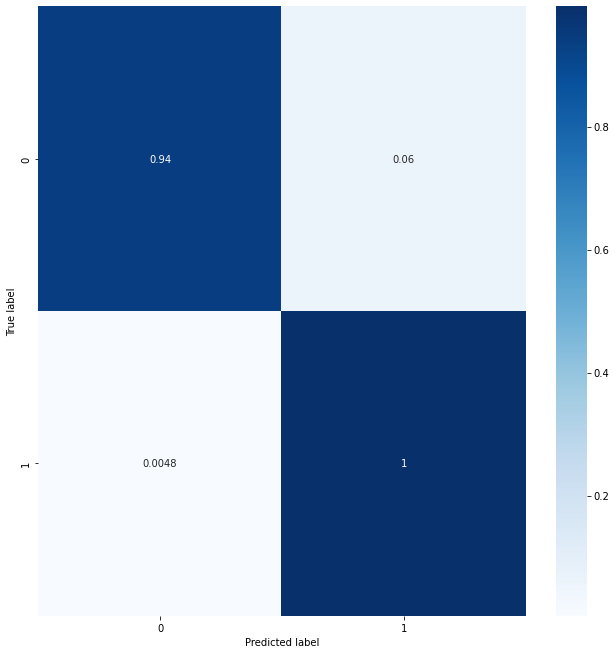

In [23]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 21**

In [24]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(21,22):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.21
(1200, 32, 256, 1)
(1200,) (570,) (630,)
(1200,) (240,) (960,)


3576

# **Valence**

In [25]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.1071 - accuracy: 0.5319 - val_loss: 0.6727 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7815 - accuracy: 0.5813 - val_loss: 0.6760 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7141 - accuracy: 0.5916 - val_loss: 0.6733 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7301 - accuracy: 0.5864 - val_loss: 0.6730 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6453 - accuracy: 0.6389 - val_loss: 0.6696 - val_accuracy: 0.5370
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6638 - accuracy: 0.6379 - val_loss: 0.6645 - val_accuracy: 0.5463
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6544 - accuracy: 0.6286 - val_loss: 0.6566 - val_accuracy: 

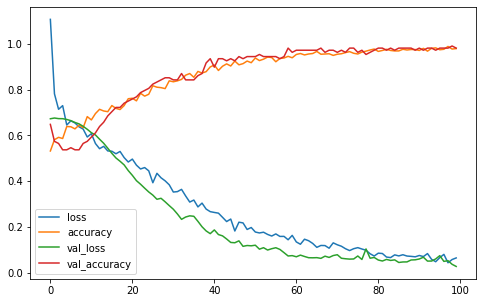

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8880 - accuracy: 0.5051 - val_loss: 0.6852 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7614 - accuracy: 0.5597 - val_loss: 0.6774 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7323 - accuracy: 0.5802 - val_loss: 0.6690 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6803 - accuracy: 0.5874 - val_loss: 0.6601 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6685 - accuracy: 0.6265 - val_loss: 0.6508 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6639 - accuracy: 0.6204 - val_loss: 0.6419 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6321 - accuracy: 0.6255 - val_loss: 0.6317 - val_accuracy: 

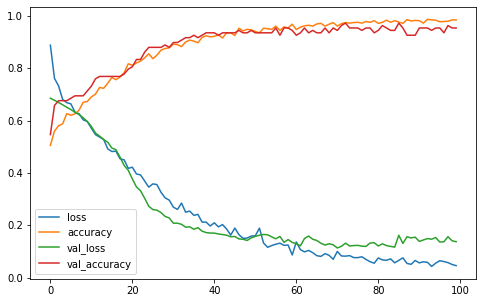

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9584 - accuracy: 0.4990 - val_loss: 0.6759 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7694 - accuracy: 0.5854 - val_loss: 0.6621 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7320 - accuracy: 0.5977 - val_loss: 0.6555 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.6307 - val_loss: 0.6517 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6783 - accuracy: 0.6224 - val_loss: 0.6494 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6460 - accuracy: 0.6255 - val_loss: 0.6469 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6157 - accuracy: 0.6667 - val_loss: 0.6480 - val_accuracy

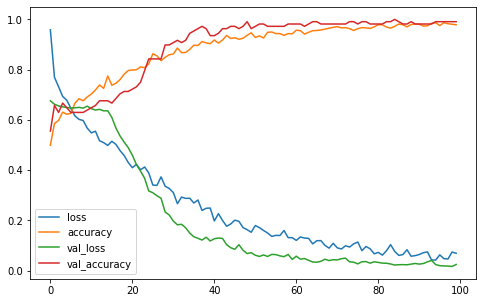

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9555 - accuracy: 0.5237 - val_loss: 0.6821 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7889 - accuracy: 0.5216 - val_loss: 0.6822 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.5936 - val_loss: 0.6776 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7173 - accuracy: 0.5761 - val_loss: 0.6738 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6697 - accuracy: 0.6183 - val_loss: 0.6697 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6429 - accuracy: 0.6235 - val_loss: 0.6646 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6217 - accuracy: 0.6708 - val_loss: 0.6612 - val_accuracy: 

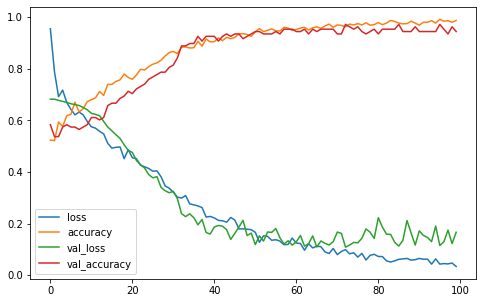

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8999 - accuracy: 0.5175 - val_loss: 0.6791 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7334 - accuracy: 0.5977 - val_loss: 0.6661 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6880 - accuracy: 0.6039 - val_loss: 0.6605 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6796 - accuracy: 0.6533 - val_loss: 0.6739 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6371 - accuracy: 0.6543 - val_loss: 0.7047 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6134 - accuracy: 0.6698 - val_loss: 0.7233 - val_accuracy: 0.5093
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6302 - accuracy: 0.6574 - val_loss: 0.7644 - val_accuracy: 

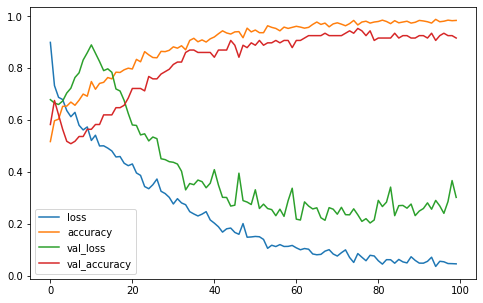

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9176 - accuracy: 0.5247 - val_loss: 0.6703 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7789 - accuracy: 0.5823 - val_loss: 0.6765 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7493 - accuracy: 0.5751 - val_loss: 0.6937 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7402 - accuracy: 0.5772 - val_loss: 0.7143 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6714 - accuracy: 0.5947 - val_loss: 0.7308 - val_accuracy: 0.4537
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6553 - accuracy: 0.6451 - val_loss: 0.7523 - val_accuracy: 0.4537
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6443 - accuracy: 0.6389 - val_loss: 0.7765 - val_accuracy: 

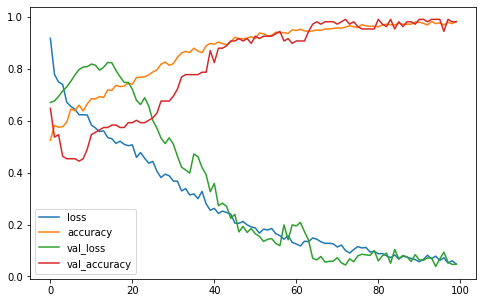

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8716 - accuracy: 0.5144 - val_loss: 0.6733 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7192 - accuracy: 0.6029 - val_loss: 0.6626 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7008 - accuracy: 0.5885 - val_loss: 0.6539 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5957 - val_loss: 0.6481 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6193 - accuracy: 0.6533 - val_loss: 0.6396 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6304 - accuracy: 0.6193 - val_loss: 0.6323 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5814 - accuracy: 0.6831 - val_loss: 0.6302 - val_accuracy: 

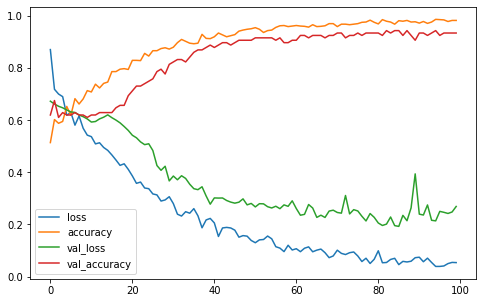

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9446 - accuracy: 0.5113 - val_loss: 0.6723 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8348 - accuracy: 0.5689 - val_loss: 0.6721 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7526 - accuracy: 0.5864 - val_loss: 0.6734 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7270 - accuracy: 0.5947 - val_loss: 0.6697 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6659 - accuracy: 0.6327 - val_loss: 0.6668 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6576 - accuracy: 0.6132 - val_loss: 0.6642 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6388 - accuracy: 0.6409 - val_loss: 0.6563 - val_accuracy

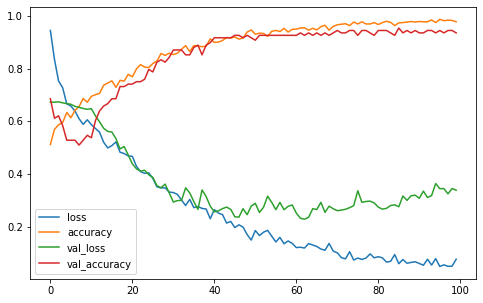

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8970 - accuracy: 0.5298 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7572 - accuracy: 0.5885 - val_loss: 0.6769 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7372 - accuracy: 0.5710 - val_loss: 0.6737 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.6111 - val_loss: 0.6676 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6941 - accuracy: 0.6029 - val_loss: 0.6610 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6495 - accuracy: 0.6307 - val_loss: 0.6543 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6466 - accuracy: 0.6420 - val_loss: 0.6466 - val_accuracy

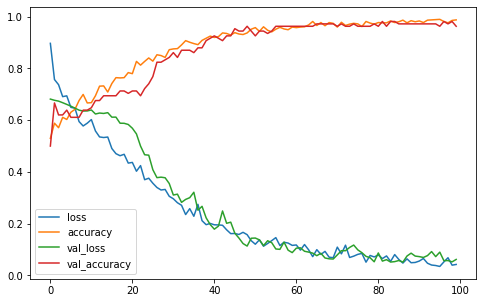

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9506 - accuracy: 0.5370 - val_loss: 0.6762 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8105 - accuracy: 0.5761 - val_loss: 0.6714 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7395 - accuracy: 0.6039 - val_loss: 0.6675 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7323 - accuracy: 0.5833 - val_loss: 0.6721 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6624 - accuracy: 0.6389 - val_loss: 0.6702 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6669 - accuracy: 0.6080 - val_loss: 0.6667 - val_accuracy: 0.5463
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6473 - accuracy: 0.6368 - val_loss: 0.6701 - val_accurac

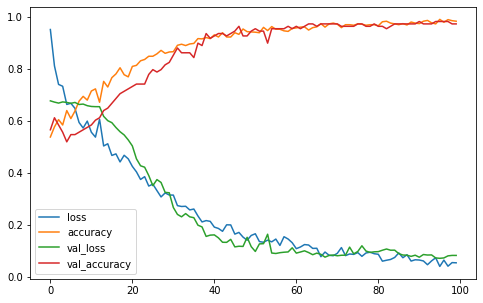

In [26]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9524999916553497
F1_Score  : 0.9515521076524474


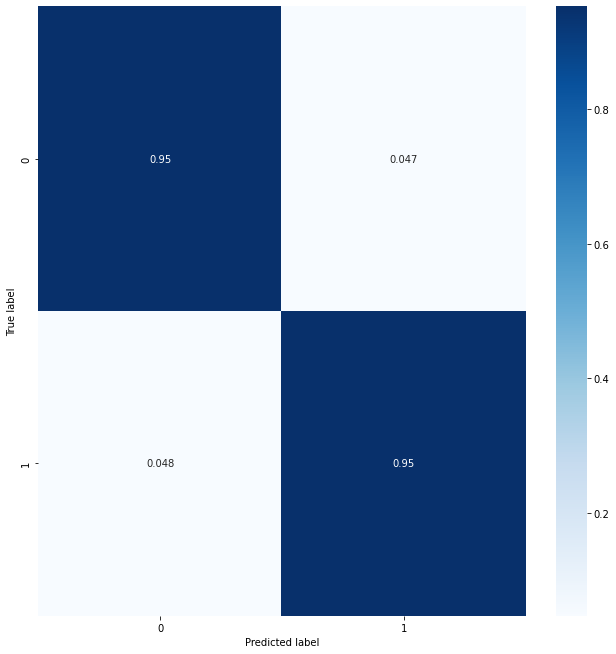

In [27]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [28]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.9998 - accuracy: 0.5288 - val_loss: 0.6899 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8490 - accuracy: 0.5998 - val_loss: 0.6679 - val_accuracy: 0.7685
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7623 - accuracy: 0.6111 - val_loss: 0.6521 - val_accuracy: 0.7685
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7191 - accuracy: 0.6132 - val_loss: 0.6371 - val_accuracy: 0.7963
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7223 - accuracy: 0.6286 - val_loss: 0.6314 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6792 - accuracy: 0.6173 - val_loss: 0.6216 - val_accuracy: 0.8333
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6780 - accuracy: 0.6317 - val_loss: 0.6064 - val_accuracy: 

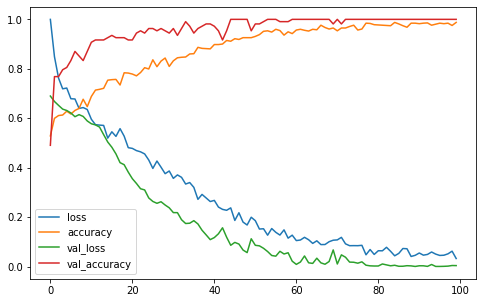

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9552 - accuracy: 0.4691 - val_loss: 0.6946 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8082 - accuracy: 0.5453 - val_loss: 0.6711 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7622 - accuracy: 0.6039 - val_loss: 0.6563 - val_accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7805 - accuracy: 0.5967 - val_loss: 0.6506 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6719 - accuracy: 0.6183 - val_loss: 0.6353 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6533 - accuracy: 0.6358 - val_loss: 0.6169 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6676 - accuracy: 0.6502 - val_loss: 0.6048 - val_accuracy: 

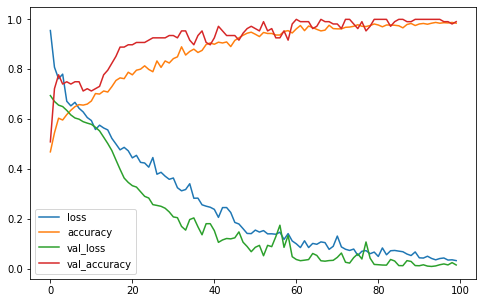

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9717 - accuracy: 0.5278 - val_loss: 0.6954 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8020 - accuracy: 0.5607 - val_loss: 0.6495 - val_accuracy: 0.8333
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8151 - accuracy: 0.5504 - val_loss: 0.6360 - val_accuracy: 0.8333
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7109 - accuracy: 0.5844 - val_loss: 0.6072 - val_accuracy: 0.8704
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6400 - accuracy: 0.6430 - val_loss: 0.5799 - val_accuracy: 0.8704
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6518 - accuracy: 0.6656 - val_loss: 0.5556 - val_accuracy: 0.8796
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6772 - accuracy: 0.6224 - val_loss: 0.5490 - val_accuracy: 

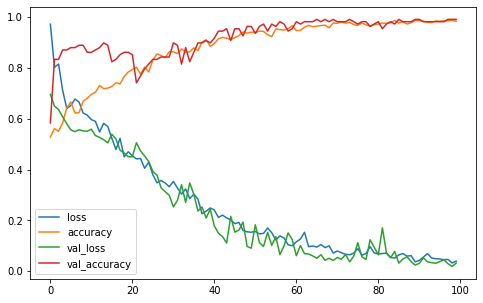

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8950 - accuracy: 0.6193 - val_loss: 0.6976 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7541 - accuracy: 0.5977 - val_loss: 0.6704 - val_accuracy: 0.8148
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7820 - accuracy: 0.5864 - val_loss: 0.6639 - val_accuracy: 0.8333
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6942 - accuracy: 0.6152 - val_loss: 0.6630 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6474 - accuracy: 0.6523 - val_loss: 0.6656 - val_accuracy: 0.7407
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6802 - accuracy: 0.6543 - val_loss: 0.6630 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6146 - accuracy: 0.6821 - val_loss: 0.6590 - val_accuracy: 

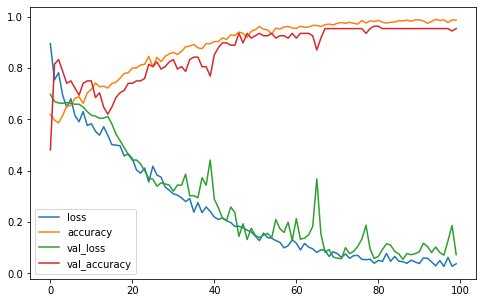

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9144 - accuracy: 0.4660 - val_loss: 0.7018 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8282 - accuracy: 0.5514 - val_loss: 0.6619 - val_accuracy: 0.7407
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7873 - accuracy: 0.5473 - val_loss: 0.6480 - val_accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7092 - accuracy: 0.5669 - val_loss: 0.6366 - val_accuracy: 0.7778
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6663 - accuracy: 0.6265 - val_loss: 0.6287 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6785 - accuracy: 0.6224 - val_loss: 0.6332 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6269 - accuracy: 0.6595 - val_loss: 0.6267 - val_accuracy: 

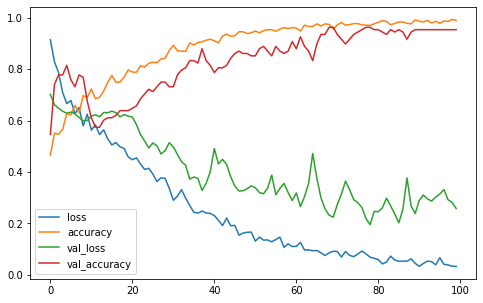

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8640 - accuracy: 0.5556 - val_loss: 0.6985 - val_accuracy: 0.3426
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8267 - accuracy: 0.5288 - val_loss: 0.6670 - val_accuracy: 0.7870
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7796 - accuracy: 0.5854 - val_loss: 0.6349 - val_accuracy: 0.8704
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6877 - accuracy: 0.6420 - val_loss: 0.6115 - val_accuracy: 0.8704
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6701 - accuracy: 0.6605 - val_loss: 0.5953 - val_accuracy: 0.8704
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6643 - accuracy: 0.6749 - val_loss: 0.5854 - val_accuracy: 0.8704
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.6821 - val_loss: 0.5762 - val_accuracy: 

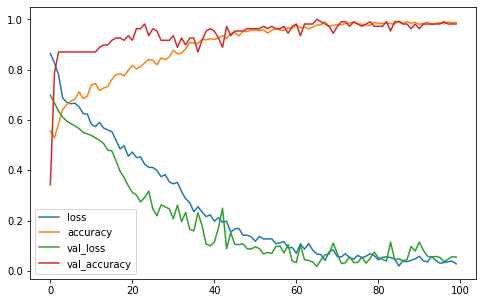

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8958 - accuracy: 0.4784 - val_loss: 0.7066 - val_accuracy: 0.3056
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8319 - accuracy: 0.5442 - val_loss: 0.6719 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7531 - accuracy: 0.5720 - val_loss: 0.6480 - val_accuracy: 0.7685
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7081 - accuracy: 0.5967 - val_loss: 0.6261 - val_accuracy: 0.8148
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6710 - accuracy: 0.5947 - val_loss: 0.6143 - val_accuracy: 0.8241
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6630 - accuracy: 0.6214 - val_loss: 0.6012 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6538 - accuracy: 0.6451 - val_loss: 0.5866 - val_accuracy: 

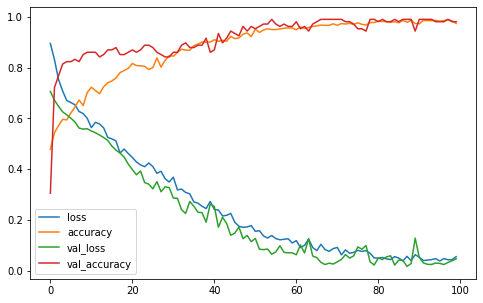

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.1940 - accuracy: 0.7058 - val_loss: 0.6945 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8750 - accuracy: 0.6461 - val_loss: 0.6815 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7720 - accuracy: 0.6327 - val_loss: 0.6669 - val_accuracy: 0.7130
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7410 - accuracy: 0.6327 - val_loss: 0.6562 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7106 - accuracy: 0.6317 - val_loss: 0.6454 - val_accuracy: 0.7870
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.6646 - val_loss: 0.6370 - val_accuracy: 0.7778
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6748 - accuracy: 0.6955 - val_loss: 0.6344 - val_accuracy: 

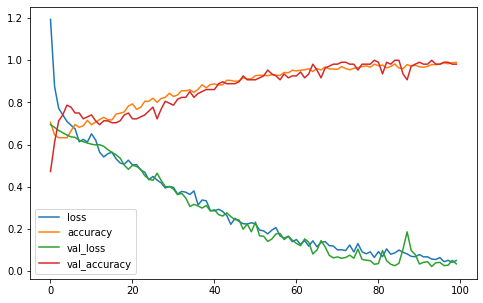

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8663 - accuracy: 0.4198 - val_loss: 0.6955 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7586 - accuracy: 0.5267 - val_loss: 0.6691 - val_accuracy: 0.8056
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7274 - accuracy: 0.5916 - val_loss: 0.6576 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6619 - accuracy: 0.6060 - val_loss: 0.6532 - val_accuracy: 0.8333
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6721 - accuracy: 0.6214 - val_loss: 0.6397 - val_accuracy: 0.8241
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6215 - accuracy: 0.6687 - val_loss: 0.6377 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6211 - accuracy: 0.6307 - val_loss: 0.6400 - val_accura

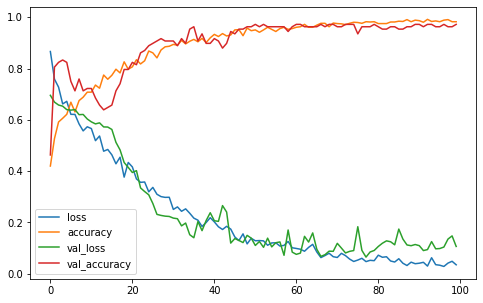

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.1274 - accuracy: 0.6790 - val_loss: 0.7310 - val_accuracy: 0.2500
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8963 - accuracy: 0.6070 - val_loss: 0.6945 - val_accuracy: 0.5648
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8627 - accuracy: 0.5854 - val_loss: 0.6693 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7964 - accuracy: 0.5916 - val_loss: 0.6497 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7231 - accuracy: 0.6317 - val_loss: 0.6377 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7459 - accuracy: 0.6348 - val_loss: 0.6345 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7062 - accuracy: 0.6307 - val_loss: 0.6509 - val_accu

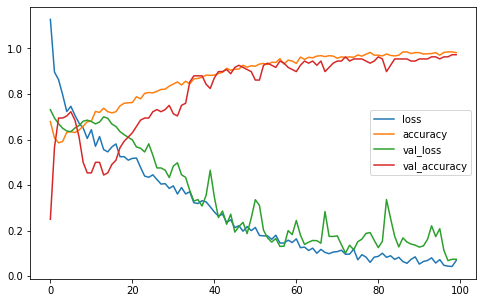

In [29]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9916666746139526
F1_Score  : 0.9827801517270889


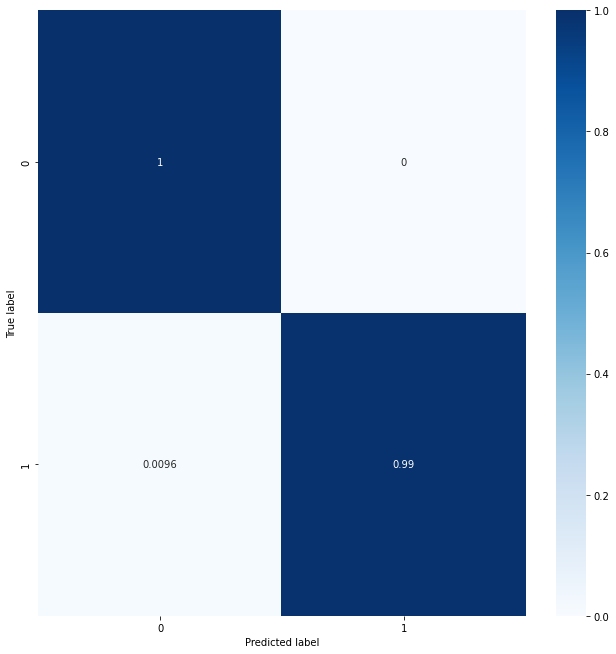

In [30]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 22**

In [31]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(22,23):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.22
(1200, 32, 256, 1)
(1200,) (600,) (600,)
(1200,) (450,) (750,)


3576

# **Valence**

In [32]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9123 - accuracy: 0.5484 - val_loss: 0.7961 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7998 - accuracy: 0.5669 - val_loss: 0.7178 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7170 - accuracy: 0.6163 - val_loss: 0.6928 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7142 - accuracy: 0.5916 - val_loss: 0.6557 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6687 - accuracy: 0.6327 - val_loss: 0.6048 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6458 - accuracy: 0.6564 - val_loss: 0.5912 - val_accuracy: 0.7778
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6295 - accuracy: 0.6852 - val_loss: 0.5640 - val_accuracy:

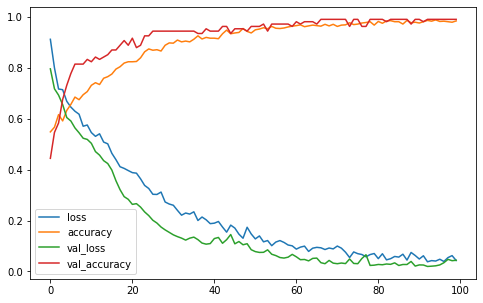

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 1.1654 - accuracy: 0.4866 - val_loss: 0.6653 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7636 - accuracy: 0.5638 - val_loss: 0.6244 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7343 - accuracy: 0.5772 - val_loss: 0.6079 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7143 - accuracy: 0.5864 - val_loss: 0.5949 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6628 - accuracy: 0.6008 - val_loss: 0.5866 - val_accuracy: 0.7685
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6649 - accuracy: 0.6152 - val_loss: 0.5766 - val_accuracy: 0.8148
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.6564 - val_loss: 0.5574 - val_accuracy: 

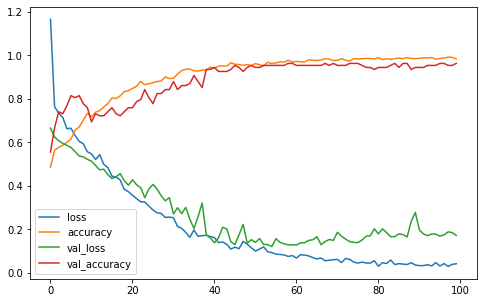

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9421 - accuracy: 0.5267 - val_loss: 0.7068 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7987 - accuracy: 0.5494 - val_loss: 0.7006 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7467 - accuracy: 0.5802 - val_loss: 0.6552 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6963 - accuracy: 0.6091 - val_loss: 0.6367 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6664 - accuracy: 0.6245 - val_loss: 0.6227 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6606 - accuracy: 0.6409 - val_loss: 0.6133 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6522 - accuracy: 0.6235 - val_loss: 0.5937 - val_accuracy: 

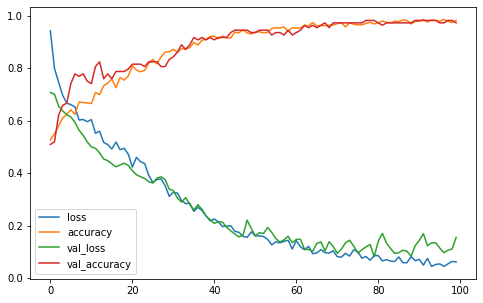

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9866 - accuracy: 0.4856 - val_loss: 0.6452 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7980 - accuracy: 0.5545 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7517 - accuracy: 0.5741 - val_loss: 0.6341 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6978 - accuracy: 0.5936 - val_loss: 0.6129 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6866 - accuracy: 0.6183 - val_loss: 0.5812 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6569 - accuracy: 0.6235 - val_loss: 0.5583 - val_accuracy: 0.7685
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6756 - accuracy: 0.6204 - val_loss: 0.5615 - val_accuracy: 

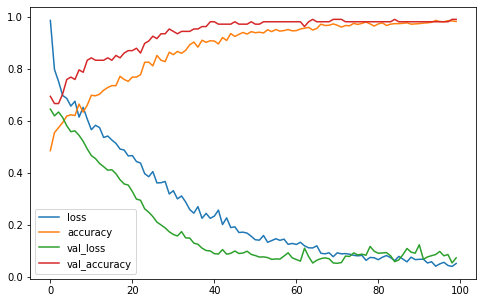

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9058 - accuracy: 0.5484 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8002 - accuracy: 0.5525 - val_loss: 0.6804 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7625 - accuracy: 0.5823 - val_loss: 0.6350 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7026 - accuracy: 0.6121 - val_loss: 0.6147 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6756 - accuracy: 0.6121 - val_loss: 0.5995 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6621 - accuracy: 0.6265 - val_loss: 0.5823 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6192 - accuracy: 0.6749 - val_loss: 0.5724 - val_accuracy: 

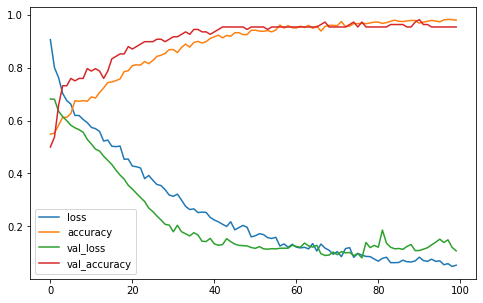

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.1419 - accuracy: 0.5206 - val_loss: 0.6481 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9532 - accuracy: 0.5041 - val_loss: 0.6603 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8098 - accuracy: 0.5679 - val_loss: 0.6424 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7717 - accuracy: 0.5730 - val_loss: 0.6223 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7168 - accuracy: 0.6132 - val_loss: 0.5849 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6824 - accuracy: 0.6337 - val_loss: 0.5589 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6894 - accuracy: 0.6245 - val_loss: 0.5439 - val_accuracy:

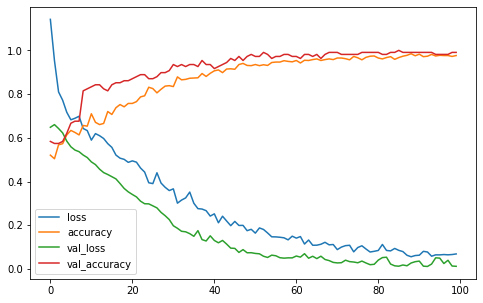

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8953 - accuracy: 0.5298 - val_loss: 0.6587 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7858 - accuracy: 0.5494 - val_loss: 0.6388 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7363 - accuracy: 0.5802 - val_loss: 0.6060 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.6091 - val_loss: 0.5877 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6489 - accuracy: 0.6389 - val_loss: 0.5633 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6151 - accuracy: 0.6533 - val_loss: 0.5517 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6509 - accuracy: 0.6348 - val_loss: 0.5271 - val_accuracy: 

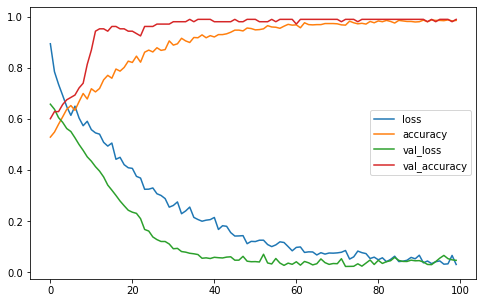

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8398 - accuracy: 0.5422 - val_loss: 0.6701 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7597 - accuracy: 0.5453 - val_loss: 0.6468 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7196 - accuracy: 0.5700 - val_loss: 0.6111 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6959 - accuracy: 0.5833 - val_loss: 0.5842 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6516 - accuracy: 0.6307 - val_loss: 0.5650 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6825 - accuracy: 0.6111 - val_loss: 0.5432 - val_accuracy: 0.7685
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6228 - accuracy: 0.6574 - val_loss: 0.5124 - val_accuracy: 

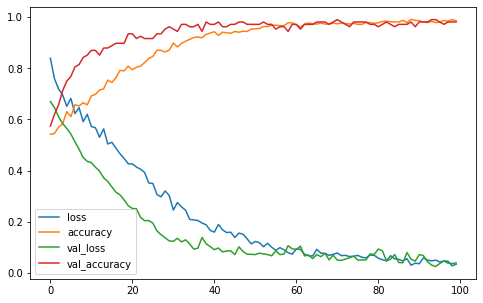

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0122 - accuracy: 0.5082 - val_loss: 0.6914 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8316 - accuracy: 0.5473 - val_loss: 0.6400 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7341 - accuracy: 0.5864 - val_loss: 0.6136 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7292 - accuracy: 0.5926 - val_loss: 0.5985 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6836 - accuracy: 0.6235 - val_loss: 0.5938 - val_accuracy: 0.7222
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6952 - accuracy: 0.6049 - val_loss: 0.5931 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6731 - accuracy: 0.6265 - val_loss: 0.5852 - val_accuracy

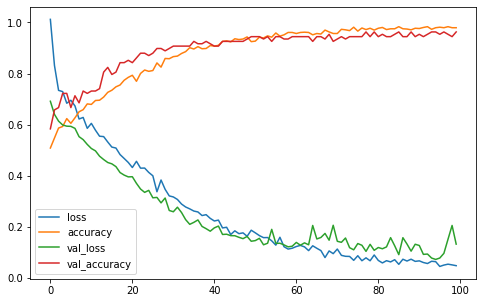

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9293 - accuracy: 0.5103 - val_loss: 0.6982 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8060 - accuracy: 0.5586 - val_loss: 0.6884 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7345 - accuracy: 0.5648 - val_loss: 0.6733 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6668 - accuracy: 0.6348 - val_loss: 0.6670 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6660 - accuracy: 0.6214 - val_loss: 0.6383 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6434 - accuracy: 0.6420 - val_loss: 0.5970 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6281 - accuracy: 0.6605 - val_loss: 0.5751 - val_accur

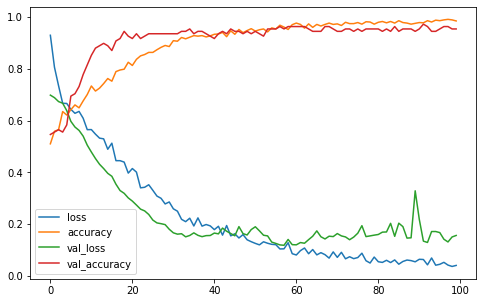

In [33]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9925000071525574
F1_Score  : 0.9924484246230444


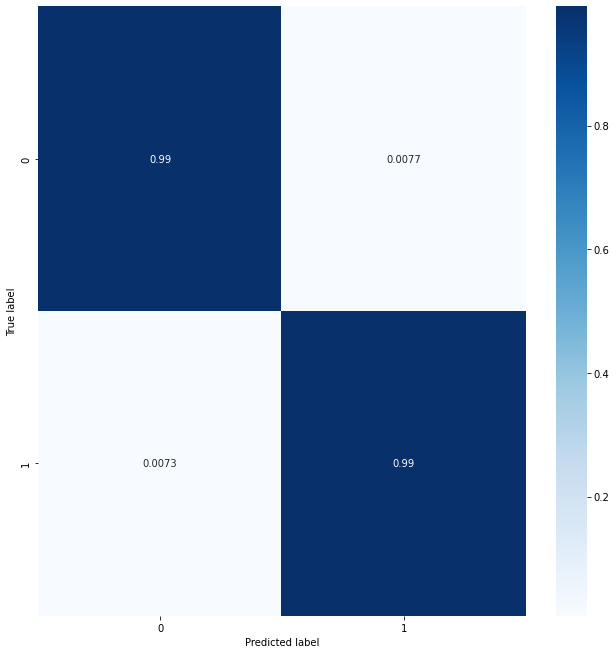

In [34]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [35]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9789 - accuracy: 0.5514 - val_loss: 0.7327 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8354 - accuracy: 0.5679 - val_loss: 0.7260 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7699 - accuracy: 0.6049 - val_loss: 0.6831 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6620 - accuracy: 0.6636 - val_loss: 0.6559 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6507 - accuracy: 0.6523 - val_loss: 0.6295 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6601 - accuracy: 0.6533 - val_loss: 0.5973 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5923 - accuracy: 0.7037 - val_loss: 0.5461 - val_accuracy: 

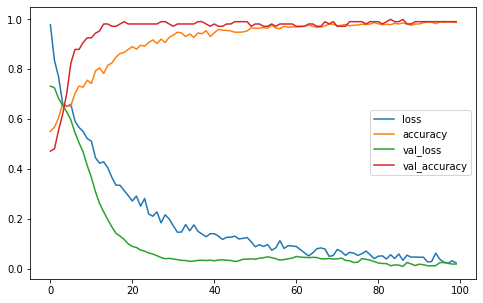

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9852 - accuracy: 0.4671 - val_loss: 0.6961 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7699 - accuracy: 0.5833 - val_loss: 0.6785 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7557 - accuracy: 0.6163 - val_loss: 0.6759 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.6430 - val_loss: 0.6846 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6605 - accuracy: 0.6584 - val_loss: 0.6758 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6052 - accuracy: 0.6646 - val_loss: 0.6251 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6010 - accuracy: 0.6852 - val_loss: 0.5799 - val_accuracy: 

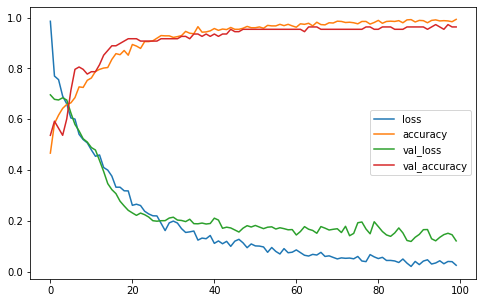

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8964 - accuracy: 0.5442 - val_loss: 0.7966 - val_accuracy: 0.3981
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8406 - accuracy: 0.5669 - val_loss: 0.7872 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7365 - accuracy: 0.6163 - val_loss: 0.7117 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7262 - accuracy: 0.6039 - val_loss: 0.6526 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6295 - accuracy: 0.6698 - val_loss: 0.6336 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6202 - accuracy: 0.6780 - val_loss: 0.6248 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6350 - accuracy: 0.6574 - val_loss: 0.5810 - val_accuracy: 

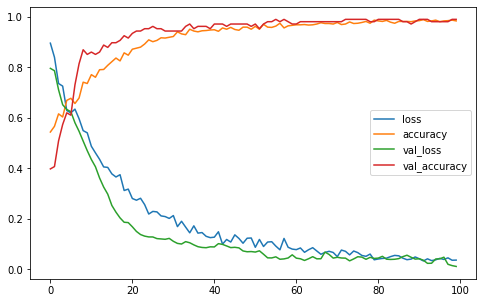

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9574 - accuracy: 0.5206 - val_loss: 0.6365 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8200 - accuracy: 0.5267 - val_loss: 0.6205 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7371 - accuracy: 0.5957 - val_loss: 0.6311 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6946 - accuracy: 0.5905 - val_loss: 0.6260 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6269 - accuracy: 0.6615 - val_loss: 0.6445 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6446 - accuracy: 0.6440 - val_loss: 0.6250 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5972 - accuracy: 0.6831 - val_loss: 0.5989 - val_accuracy: 

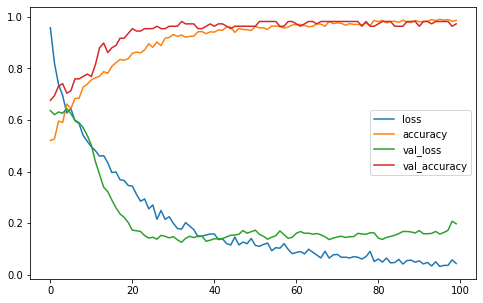

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9651 - accuracy: 0.5473 - val_loss: 0.6916 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8023 - accuracy: 0.5658 - val_loss: 0.7013 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5895 - val_loss: 0.7036 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6896 - accuracy: 0.6245 - val_loss: 0.6809 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6228 - accuracy: 0.6677 - val_loss: 0.6620 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6131 - accuracy: 0.6862 - val_loss: 0.6201 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5569 - accuracy: 0.7243 - val_loss: 0.5786 - val_accuracy: 

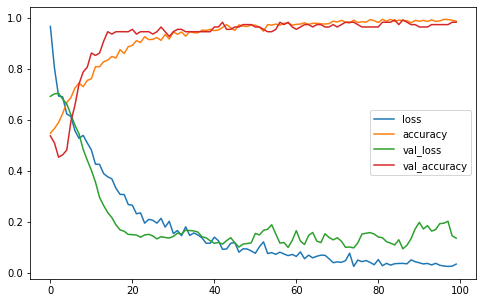

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.2801 - accuracy: 0.5267 - val_loss: 0.6815 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9862 - accuracy: 0.5586 - val_loss: 0.7404 - val_accuracy: 0.4537
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8580 - accuracy: 0.6070 - val_loss: 0.7436 - val_accuracy: 0.4167
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7232 - accuracy: 0.6430 - val_loss: 0.6664 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7465 - accuracy: 0.6399 - val_loss: 0.6716 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6459 - accuracy: 0.6790 - val_loss: 0.6473 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6722 - accuracy: 0.6564 - val_loss: 0.6136 - val_accuracy: 

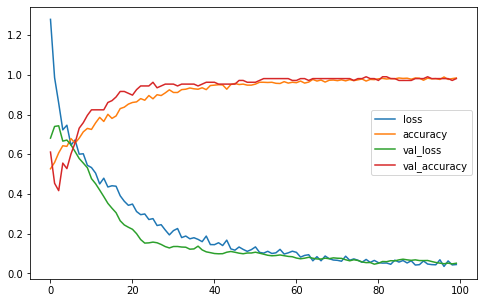

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9935 - accuracy: 0.5412 - val_loss: 0.6551 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7949 - accuracy: 0.5679 - val_loss: 0.7183 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7245 - accuracy: 0.5957 - val_loss: 0.7134 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6877 - accuracy: 0.6142 - val_loss: 0.6745 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6507 - accuracy: 0.6461 - val_loss: 0.6467 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6136 - accuracy: 0.6656 - val_loss: 0.6217 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5908 - accuracy: 0.6996 - val_loss: 0.5986 - val_accuracy: 

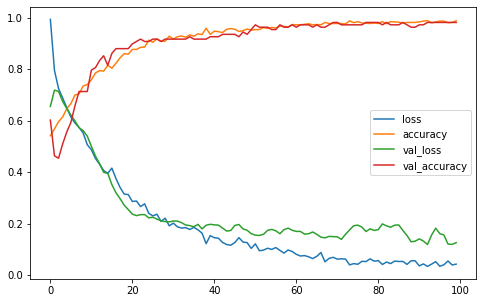

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8911 - accuracy: 0.5165 - val_loss: 0.8093 - val_accuracy: 0.3519
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8136 - accuracy: 0.5556 - val_loss: 0.6852 - val_accuracy: 0.4352
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7134 - accuracy: 0.6101 - val_loss: 0.6391 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6668 - accuracy: 0.6420 - val_loss: 0.6446 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6005 - accuracy: 0.6770 - val_loss: 0.6365 - val_accuracy: 0.5926
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6260 - accuracy: 0.6471 - val_loss: 0.6240 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5635 - accuracy: 0.7109 - val_loss: 0.5955 - val_accuracy:

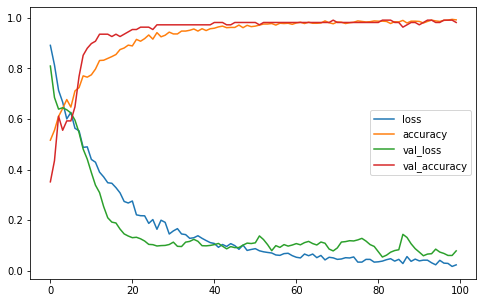

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8995 - accuracy: 0.5319 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7880 - accuracy: 0.6070 - val_loss: 0.6863 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7107 - accuracy: 0.6286 - val_loss: 0.6538 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6581 - accuracy: 0.6687 - val_loss: 0.6419 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6527 - accuracy: 0.6533 - val_loss: 0.6366 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5959 - accuracy: 0.6914 - val_loss: 0.6108 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5873 - accuracy: 0.6811 - val_loss: 0.5858 - val_accuracy

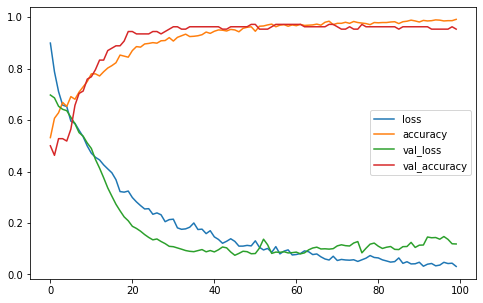

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9485 - accuracy: 0.5278 - val_loss: 0.8876 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7950 - accuracy: 0.5864 - val_loss: 0.7518 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7344 - accuracy: 0.6245 - val_loss: 0.6827 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6807 - accuracy: 0.6481 - val_loss: 0.5950 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6718 - accuracy: 0.6646 - val_loss: 0.5369 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6340 - accuracy: 0.6626 - val_loss: 0.5081 - val_accuracy: 0.8426
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.5429 - accuracy: 0.7325 - val_loss: 0.4732 - val_accura

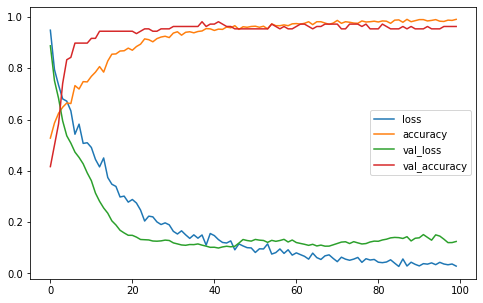

In [36]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9833333492279053
F1_Score  : 0.9794423118247145


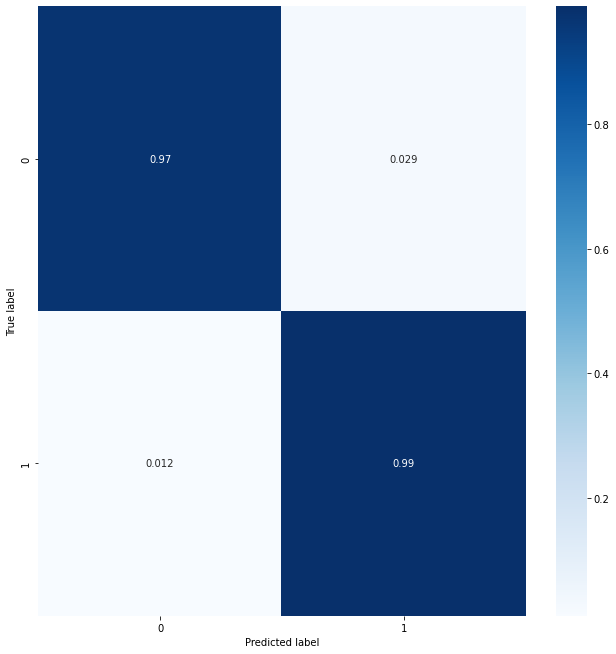

In [37]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 23**

In [38]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(23,24):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.23
(1200, 32, 256, 1)
(1200,) (390,) (810,)
(1200,) (810,) (390,)


3576

# **Valence**

In [39]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9042 - accuracy: 0.4825 - val_loss: 0.6847 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8314 - accuracy: 0.5288 - val_loss: 0.6616 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7494 - accuracy: 0.5854 - val_loss: 0.6493 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7812 - accuracy: 0.5658 - val_loss: 0.6529 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6807 - accuracy: 0.6132 - val_loss: 0.6761 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6626 - accuracy: 0.6409 - val_loss: 0.7195 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6580 - accuracy: 0.6307 - val_loss: 0.7624 - val_accuracy:

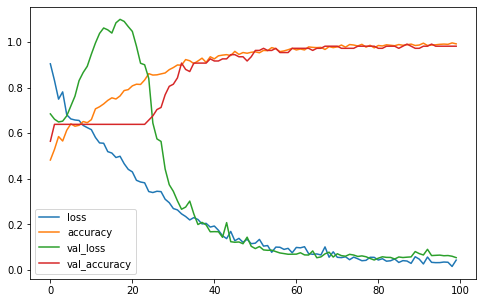

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0001 - accuracy: 0.5720 - val_loss: 0.6806 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7855 - accuracy: 0.5648 - val_loss: 0.6711 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7661 - accuracy: 0.5700 - val_loss: 0.6911 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7359 - accuracy: 0.5813 - val_loss: 0.7654 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6860 - accuracy: 0.5926 - val_loss: 0.8937 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6804 - accuracy: 0.5844 - val_loss: 0.9906 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6809 - accuracy: 0.5874 - val_loss: 1.1598 - val_accuracy: 

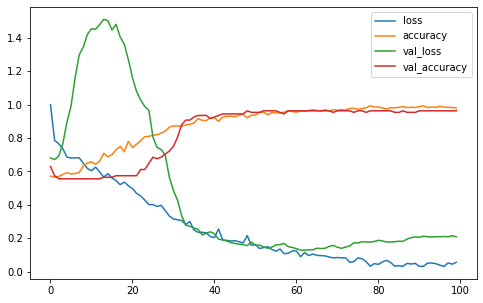

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 0.9813 - accuracy: 0.5597 - val_loss: 0.6927 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8843 - accuracy: 0.5267 - val_loss: 0.6626 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8513 - accuracy: 0.5370 - val_loss: 0.6292 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7299 - accuracy: 0.5905 - val_loss: 0.6160 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7165 - accuracy: 0.6039 - val_loss: 0.6120 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7004 - accuracy: 0.6121 - val_loss: 0.6245 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6706 - accuracy: 0.6420 - val_loss: 0.6508 - val_accuracy: 

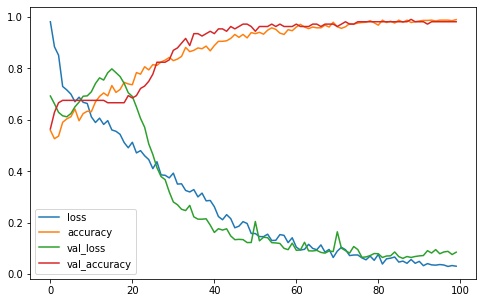

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9099 - accuracy: 0.5833 - val_loss: 0.6883 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8528 - accuracy: 0.5309 - val_loss: 0.6490 - val_accuracy: 0.7037
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7812 - accuracy: 0.5473 - val_loss: 0.6140 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7153 - accuracy: 0.6111 - val_loss: 0.6028 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7373 - accuracy: 0.6029 - val_loss: 0.6232 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6791 - accuracy: 0.6204 - val_loss: 0.6472 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6839 - accuracy: 0.5977 - val_loss: 0.6996 - val_accuracy: 

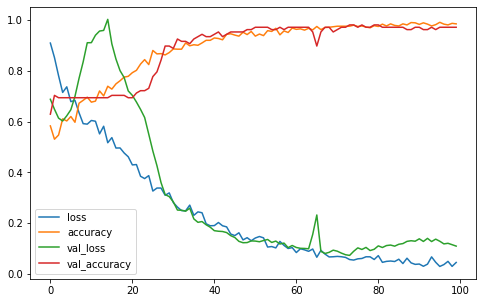

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0566 - accuracy: 0.4990 - val_loss: 0.6743 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7925 - accuracy: 0.5936 - val_loss: 0.6357 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8210 - accuracy: 0.5576 - val_loss: 0.6165 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7597 - accuracy: 0.5679 - val_loss: 0.6269 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7124 - accuracy: 0.5916 - val_loss: 0.6495 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7056 - accuracy: 0.6070 - val_loss: 0.6826 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.6214 - val_loss: 0.7132 - val_accuracy:

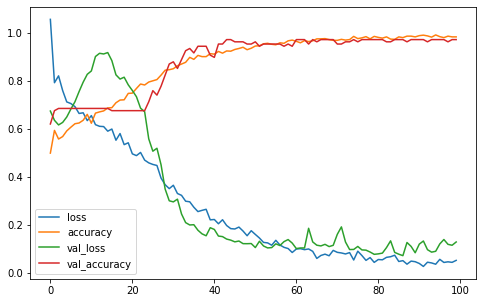

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9143 - accuracy: 0.4702 - val_loss: 0.6881 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7997 - accuracy: 0.5288 - val_loss: 0.6610 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7516 - accuracy: 0.5730 - val_loss: 0.6306 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7459 - accuracy: 0.5576 - val_loss: 0.6069 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6791 - accuracy: 0.5895 - val_loss: 0.5974 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6561 - accuracy: 0.6183 - val_loss: 0.6040 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5844 - val_loss: 0.6203 - val_accuracy: 

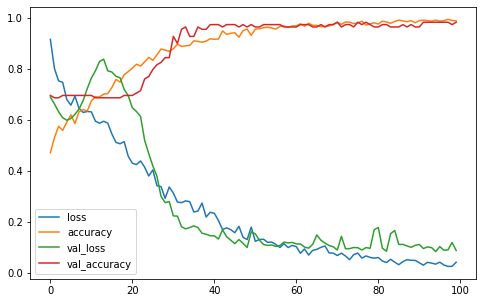

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9367 - accuracy: 0.5453 - val_loss: 0.6914 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8276 - accuracy: 0.5833 - val_loss: 0.6614 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7482 - accuracy: 0.5782 - val_loss: 0.6278 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7459 - accuracy: 0.5761 - val_loss: 0.6049 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7171 - accuracy: 0.5772 - val_loss: 0.6089 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6774 - accuracy: 0.6358 - val_loss: 0.6318 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6946 - accuracy: 0.6245 - val_loss: 0.6586 - val_accuracy:

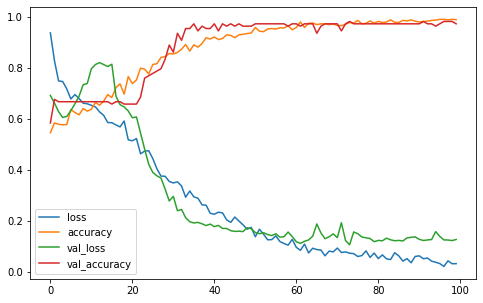

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9028 - accuracy: 0.4805 - val_loss: 0.6961 - val_accuracy: 0.2963
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7814 - accuracy: 0.5288 - val_loss: 0.6787 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7262 - accuracy: 0.5535 - val_loss: 0.6481 - val_accuracy: 0.7593
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7228 - accuracy: 0.5772 - val_loss: 0.6200 - val_accuracy: 0.7593
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7001 - accuracy: 0.5916 - val_loss: 0.5934 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6570 - accuracy: 0.6163 - val_loss: 0.5660 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6652 - accuracy: 0.5916 - val_loss: 0.5487 - val_accuracy: 

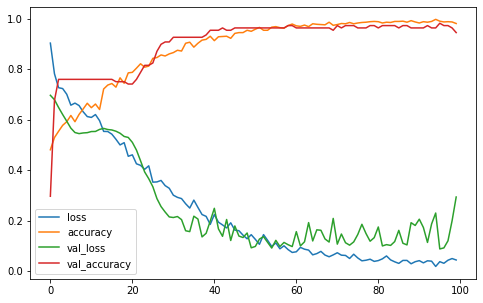

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0240 - accuracy: 0.4979 - val_loss: 0.6733 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8367 - accuracy: 0.5700 - val_loss: 0.6378 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7723 - accuracy: 0.6039 - val_loss: 0.6176 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7576 - accuracy: 0.5854 - val_loss: 0.6363 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7229 - accuracy: 0.6039 - val_loss: 0.6734 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7060 - accuracy: 0.6111 - val_loss: 0.7221 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7007 - accuracy: 0.6276 - val_loss: 0.7782 - val_accuracy

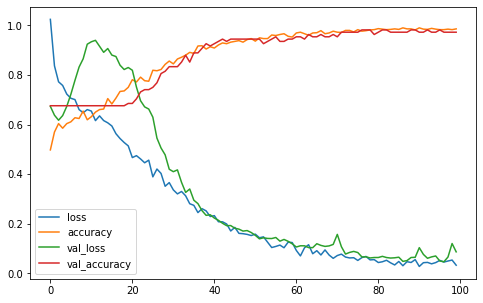

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9670 - accuracy: 0.5350 - val_loss: 0.6781 - val_accuracy: 0.7593
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8127 - accuracy: 0.5422 - val_loss: 0.6340 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7376 - accuracy: 0.5802 - val_loss: 0.6020 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7082 - accuracy: 0.6029 - val_loss: 0.5813 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7085 - accuracy: 0.6101 - val_loss: 0.5754 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7003 - accuracy: 0.5772 - val_loss: 0.5872 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6654 - accuracy: 0.6183 - val_loss: 0.6126 - val_accuracy:

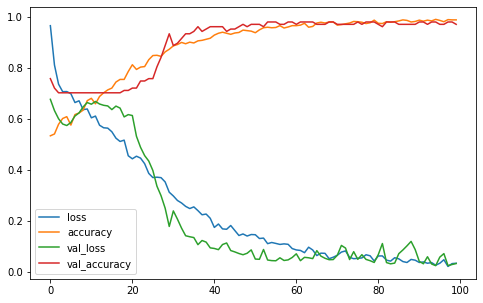

In [40]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9483333230018616
F1_Score  : 0.9391462498479239


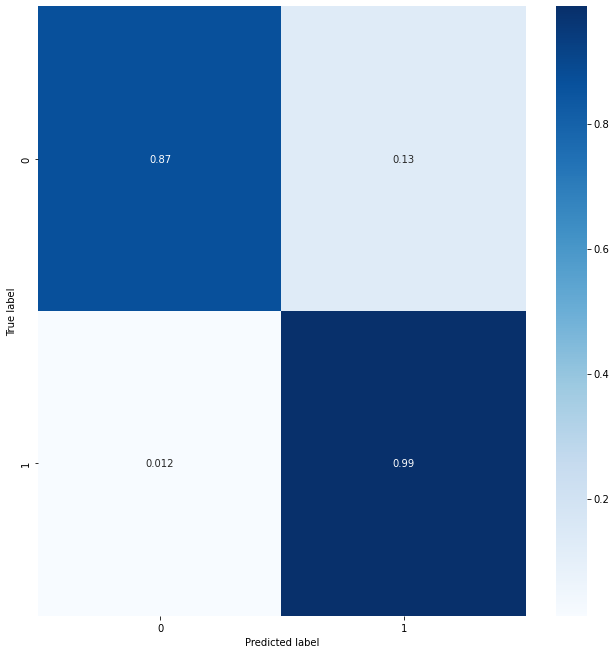

In [41]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [42]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 1.0258 - accuracy: 0.4146 - val_loss: 0.6897 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8155 - accuracy: 0.5165 - val_loss: 0.6867 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7859 - accuracy: 0.5340 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7227 - accuracy: 0.5597 - val_loss: 0.6992 - val_accuracy: 0.4815
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7222 - accuracy: 0.5648 - val_loss: 0.7095 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7100 - accuracy: 0.5576 - val_loss: 0.7145 - val_accuracy: 0.4537
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6881 - accuracy: 0.5905 - val_loss: 0.7203 - val_accuracy:

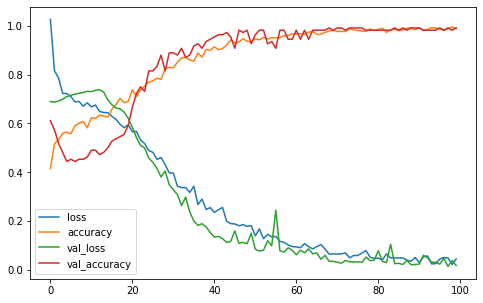

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0090 - accuracy: 0.5360 - val_loss: 0.6844 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8353 - accuracy: 0.5607 - val_loss: 0.6752 - val_accuracy: 0.7593
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7690 - accuracy: 0.5844 - val_loss: 0.6593 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7900 - accuracy: 0.5381 - val_loss: 0.6477 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7756 - accuracy: 0.5463 - val_loss: 0.6394 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7316 - accuracy: 0.5761 - val_loss: 0.6419 - val_accuracy: 0.7315
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7302 - accuracy: 0.5700 - val_loss: 0.6476 - val_accuracy: 

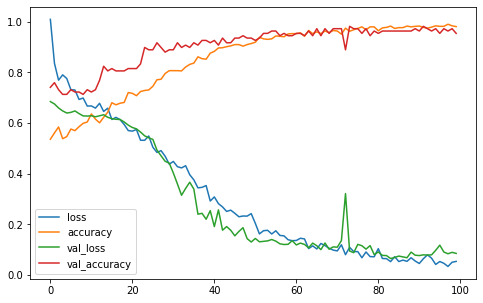

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0194 - accuracy: 0.4619 - val_loss: 0.6850 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8639 - accuracy: 0.5123 - val_loss: 0.6800 - val_accuracy: 0.7130
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7761 - accuracy: 0.5103 - val_loss: 0.6791 - val_accuracy: 0.7130
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7803 - accuracy: 0.5041 - val_loss: 0.6722 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7397 - accuracy: 0.5247 - val_loss: 0.6822 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7395 - accuracy: 0.5154 - val_loss: 0.6780 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5802 - val_loss: 0.6747 - val_accuracy: 

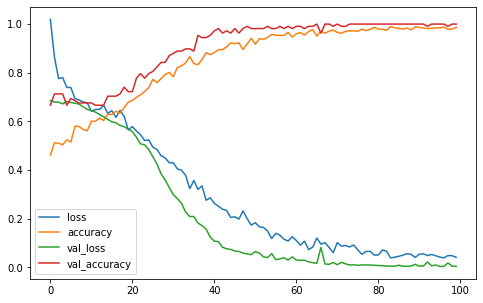

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9637 - accuracy: 0.5216 - val_loss: 0.6885 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9100 - accuracy: 0.5586 - val_loss: 0.6832 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8559 - accuracy: 0.5350 - val_loss: 0.6770 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7801 - accuracy: 0.5720 - val_loss: 0.6729 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7528 - accuracy: 0.5802 - val_loss: 0.6699 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7162 - accuracy: 0.5761 - val_loss: 0.6656 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7319 - accuracy: 0.5658 - val_loss: 0.6627 - val_accuracy: 

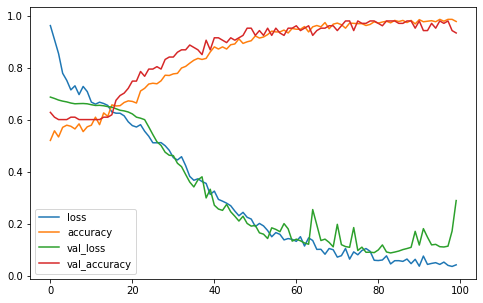

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9764 - accuracy: 0.5309 - val_loss: 0.6942 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8958 - accuracy: 0.5113 - val_loss: 0.6853 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8215 - accuracy: 0.5267 - val_loss: 0.6708 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8287 - accuracy: 0.5165 - val_loss: 0.6668 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7872 - accuracy: 0.5473 - val_loss: 0.6615 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7398 - accuracy: 0.5545 - val_loss: 0.6517 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7386 - accuracy: 0.5576 - val_loss: 0.6455 - val_accuracy: 

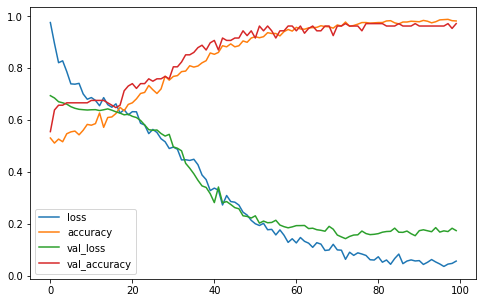

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 1.0107 - accuracy: 0.4928 - val_loss: 0.6972 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8677 - accuracy: 0.5247 - val_loss: 0.6866 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8297 - accuracy: 0.5401 - val_loss: 0.6754 - val_accuracy: 0.7130
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7730 - accuracy: 0.5514 - val_loss: 0.6613 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7660 - accuracy: 0.5586 - val_loss: 0.6565 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7366 - accuracy: 0.5679 - val_loss: 0.6515 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6961 - accuracy: 0.6019 - val_loss: 0.6482 - val_accuracy: 

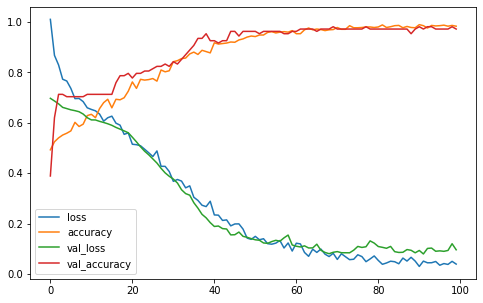

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9510 - accuracy: 0.5340 - val_loss: 0.6895 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8767 - accuracy: 0.5556 - val_loss: 0.6701 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7948 - accuracy: 0.5730 - val_loss: 0.6433 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7439 - accuracy: 0.5792 - val_loss: 0.6242 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7477 - accuracy: 0.5597 - val_loss: 0.6101 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7266 - accuracy: 0.5617 - val_loss: 0.5939 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7011 - accuracy: 0.5823 - val_loss: 0.5756 - val_accura

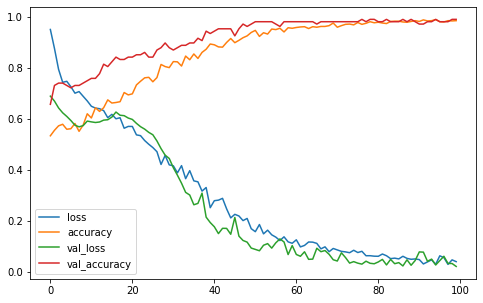

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9920 - accuracy: 0.5093 - val_loss: 0.6901 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8853 - accuracy: 0.5144 - val_loss: 0.6884 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8764 - accuracy: 0.5082 - val_loss: 0.6768 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8447 - accuracy: 0.5216 - val_loss: 0.6673 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7765 - accuracy: 0.5689 - val_loss: 0.6614 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7307 - accuracy: 0.5648 - val_loss: 0.6602 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7629 - accuracy: 0.5566 - val_loss: 0.6584 - val_accuracy: 

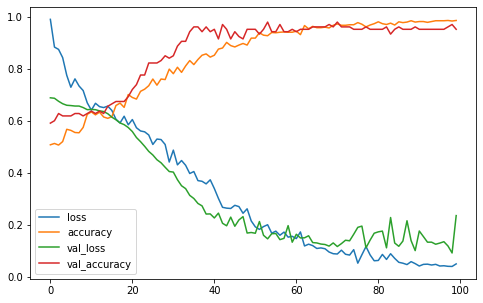

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9587 - accuracy: 0.5453 - val_loss: 0.6895 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9141 - accuracy: 0.4835 - val_loss: 0.6831 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8081 - accuracy: 0.5288 - val_loss: 0.6752 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7600 - accuracy: 0.5556 - val_loss: 0.6666 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7693 - accuracy: 0.5134 - val_loss: 0.6687 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7094 - accuracy: 0.5669 - val_loss: 0.6816 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6951 - accuracy: 0.5566 - val_loss: 0.6691 - val_accuracy: 

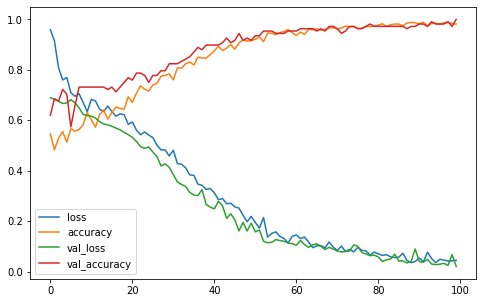

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0209 - accuracy: 0.5566 - val_loss: 0.6961 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9882 - accuracy: 0.4969 - val_loss: 0.6716 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8881 - accuracy: 0.5237 - val_loss: 0.6528 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8215 - accuracy: 0.5658 - val_loss: 0.6467 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7922 - accuracy: 0.5761 - val_loss: 0.6420 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7500 - accuracy: 0.5813 - val_loss: 0.6405 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7314 - accuracy: 0.5813 - val_loss: 0.6452 - val_accurac

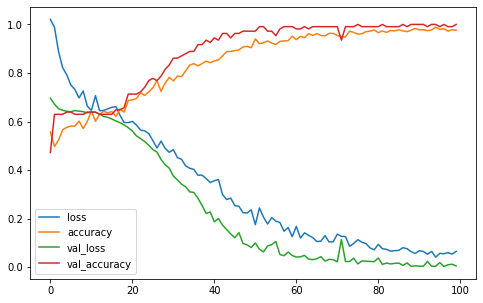

In [43]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9699999988079071
F1_Score  : 0.9664644250043664


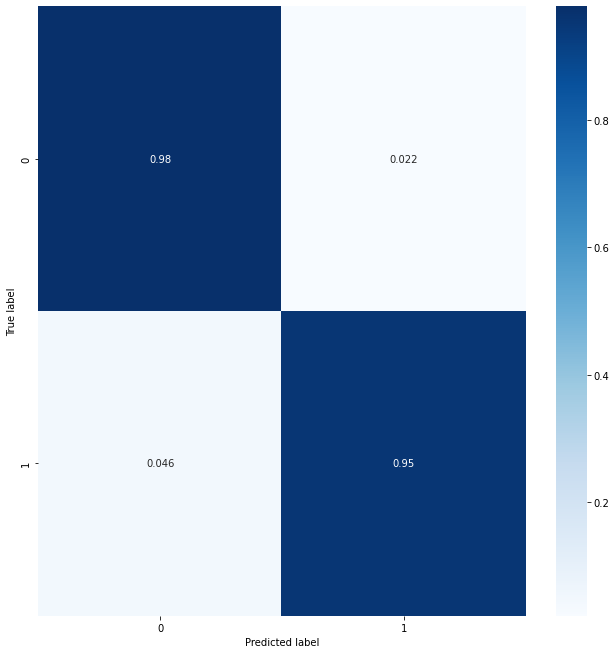

In [44]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 24**

In [45]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(24,25):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.24
(1200, 32, 256, 1)
(1200,) (630,) (570,)
(1200,) (210,) (990,)


3576

# **Valence**

In [46]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.8318 - accuracy: 0.5514 - val_loss: 0.6761 - val_accuracy: 0.6574
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7033 - accuracy: 0.6070 - val_loss: 0.6659 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6711 - accuracy: 0.6337 - val_loss: 0.6558 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6609 - accuracy: 0.6173 - val_loss: 0.6358 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6545 - accuracy: 0.6605 - val_loss: 0.6225 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6224 - accuracy: 0.6667 - val_loss: 0.6091 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5983 - accuracy: 0.6944 - val_loss: 0.5869 - val_accuracy: 

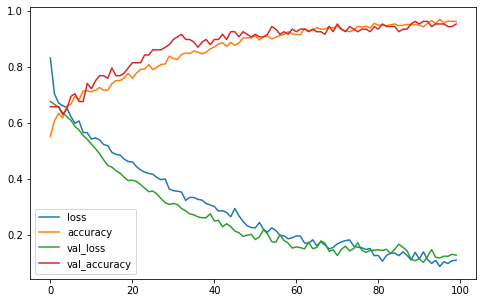

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.9122 - accuracy: 0.5381 - val_loss: 0.6635 - val_accuracy: 0.6944
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7913 - accuracy: 0.5792 - val_loss: 0.6439 - val_accuracy: 0.7685
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7572 - accuracy: 0.5926 - val_loss: 0.6323 - val_accuracy: 0.7130
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7244 - accuracy: 0.6235 - val_loss: 0.6288 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7155 - accuracy: 0.6255 - val_loss: 0.6354 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6571 - accuracy: 0.6708 - val_loss: 0.6303 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6252 - accuracy: 0.6770 - val_loss: 0.6130 - val_accuracy:

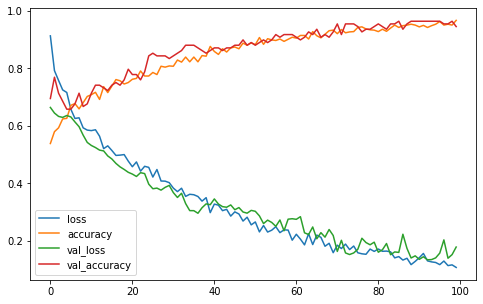

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9210 - accuracy: 0.5350 - val_loss: 0.6798 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7549 - accuracy: 0.6163 - val_loss: 0.6668 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7320 - accuracy: 0.6163 - val_loss: 0.6524 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.6235 - val_loss: 0.6375 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6995 - accuracy: 0.6389 - val_loss: 0.6232 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6506 - accuracy: 0.6615 - val_loss: 0.6091 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6002 - accuracy: 0.6852 - val_loss: 0.6002 - val_accuracy: 

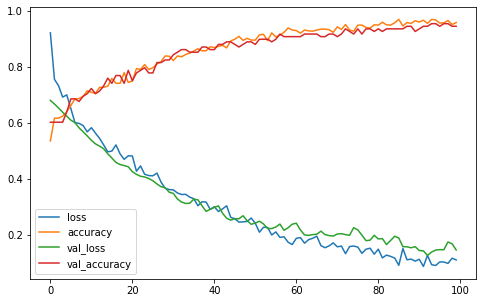

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9839 - accuracy: 0.5144 - val_loss: 0.6612 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8866 - accuracy: 0.5761 - val_loss: 0.6424 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7754 - accuracy: 0.6029 - val_loss: 0.6122 - val_accuracy: 0.7222
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7534 - accuracy: 0.6142 - val_loss: 0.6035 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7609 - accuracy: 0.6327 - val_loss: 0.5987 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.6698 - val_loss: 0.5922 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7314 - accuracy: 0.6327 - val_loss: 0.5880 - val_accuracy: 

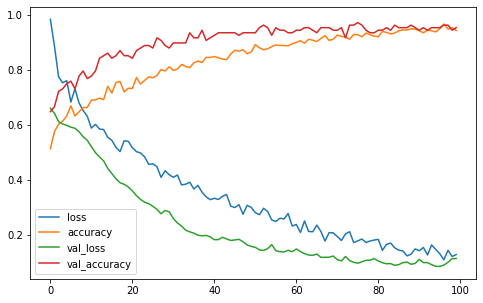

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8512 - accuracy: 0.5216 - val_loss: 0.6537 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7524 - accuracy: 0.5947 - val_loss: 0.6383 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7149 - accuracy: 0.6276 - val_loss: 0.6327 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6790 - accuracy: 0.6389 - val_loss: 0.6278 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6840 - accuracy: 0.6461 - val_loss: 0.6175 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6275 - accuracy: 0.6471 - val_loss: 0.5954 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6251 - accuracy: 0.6677 - val_loss: 0.5747 - val_accuracy: 

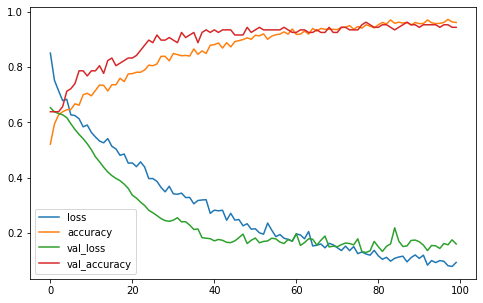

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8093 - accuracy: 0.5566 - val_loss: 0.6684 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7735 - accuracy: 0.5658 - val_loss: 0.6473 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7114 - accuracy: 0.6080 - val_loss: 0.6290 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6605 - accuracy: 0.6389 - val_loss: 0.6152 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6402 - accuracy: 0.6440 - val_loss: 0.5981 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6209 - accuracy: 0.6759 - val_loss: 0.5832 - val_accuracy: 0.7685
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6280 - accuracy: 0.6636 - val_loss: 0.5633 - val_accuracy: 

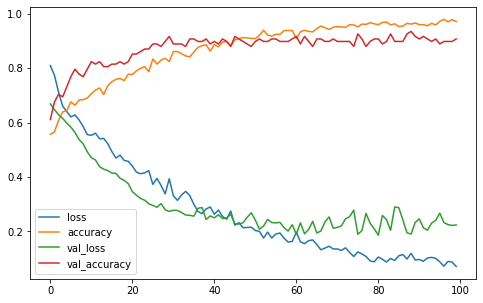

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8970 - accuracy: 0.5237 - val_loss: 0.6529 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7520 - accuracy: 0.6121 - val_loss: 0.6374 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6807 - accuracy: 0.6471 - val_loss: 0.6297 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6877 - accuracy: 0.6214 - val_loss: 0.6206 - val_accuracy: 0.6759
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6782 - accuracy: 0.6512 - val_loss: 0.6025 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6283 - accuracy: 0.6718 - val_loss: 0.5830 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6293 - accuracy: 0.6564 - val_loss: 0.5761 - val_accuracy: 

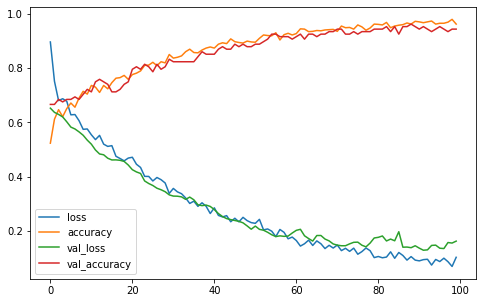

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8951 - accuracy: 0.5494 - val_loss: 0.6868 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8096 - accuracy: 0.5988 - val_loss: 0.6581 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6992 - accuracy: 0.6358 - val_loss: 0.6430 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7189 - accuracy: 0.6399 - val_loss: 0.6323 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7094 - accuracy: 0.6502 - val_loss: 0.6302 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6581 - accuracy: 0.6636 - val_loss: 0.6149 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6443 - accuracy: 0.6698 - val_loss: 0.5949 - val_accuracy: 

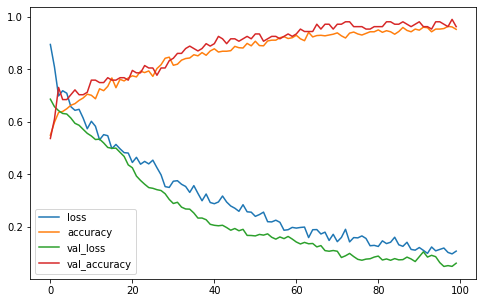

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9564 - accuracy: 0.5525 - val_loss: 0.6009 - val_accuracy: 0.7593
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8245 - accuracy: 0.5782 - val_loss: 0.6209 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7816 - accuracy: 0.5947 - val_loss: 0.6194 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7423 - accuracy: 0.6152 - val_loss: 0.6133 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6430 - accuracy: 0.6770 - val_loss: 0.5970 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6569 - accuracy: 0.6595 - val_loss: 0.5818 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6540 - accuracy: 0.6523 - val_loss: 0.5717 - val_accuracy:

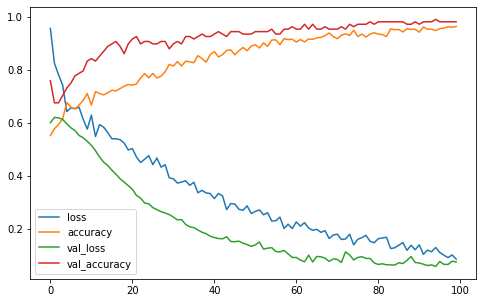

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 1.0917 - accuracy: 0.5556 - val_loss: 0.6359 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.8523 - accuracy: 0.5833 - val_loss: 0.6710 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7744 - accuracy: 0.6019 - val_loss: 0.6720 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7306 - accuracy: 0.6070 - val_loss: 0.6616 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7212 - accuracy: 0.6111 - val_loss: 0.6554 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6906 - accuracy: 0.6255 - val_loss: 0.6215 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6616 - accuracy: 0.6358 - val_loss: 0.5915 - val_accu

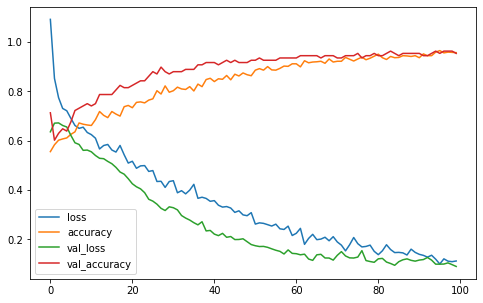

In [47]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9516666531562805
F1_Score  : 0.9515329332054563


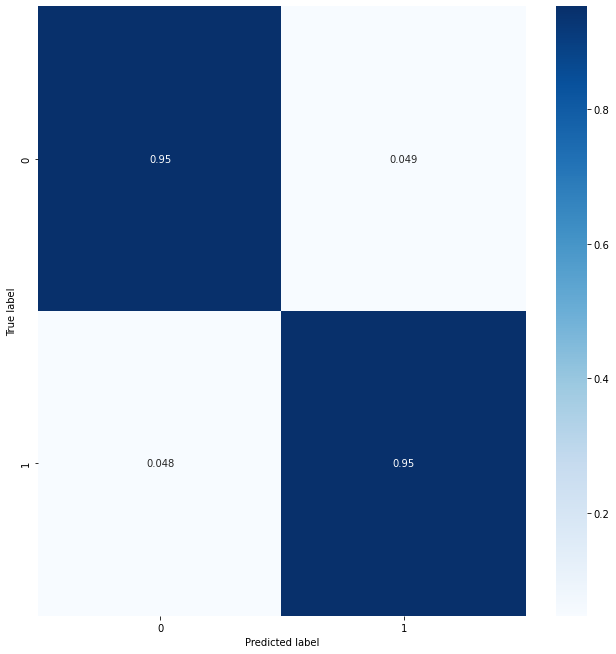

In [48]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [49]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 1) (120, 32, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8313 - accuracy: 0.5237 - val_loss: 0.4513 - val_accuracy: 0.8426
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6888 - accuracy: 0.6008 - val_loss: 0.4015 - val_accuracy: 0.8611
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6448 - accuracy: 0.6605 - val_loss: 0.3993 - val_accuracy: 0.8981
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6602 - accuracy: 0.6656 - val_loss: 0.4116 - val_accuracy: 0.9167
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5782 - accuracy: 0.6770 - val_loss: 0.4286 - val_accuracy: 0.8519
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5444 - accuracy: 0.7088 - val_loss: 0.4312 - val_accuracy: 0.8426
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5795 - accuracy: 0.7016 - val_loss: 0.4329 - val_accuracy: 

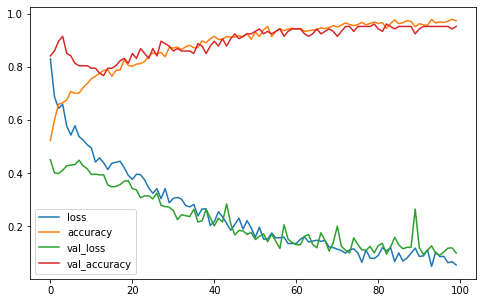

Results for fold 2
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8317 - accuracy: 0.5669 - val_loss: 0.3791 - val_accuracy: 0.8519
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7059 - accuracy: 0.6080 - val_loss: 0.3509 - val_accuracy: 0.8426
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6472 - accuracy: 0.6553 - val_loss: 0.3735 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5973 - accuracy: 0.6862 - val_loss: 0.4077 - val_accuracy: 0.8611
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5677 - accuracy: 0.7047 - val_loss: 0.4191 - val_accuracy: 0.8426
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.5900 - accuracy: 0.6996 - val_loss: 0.4305 - val_accuracy: 0.7963
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5905 - accuracy: 0.7366 - val_loss: 0.4397 - val_accuracy:

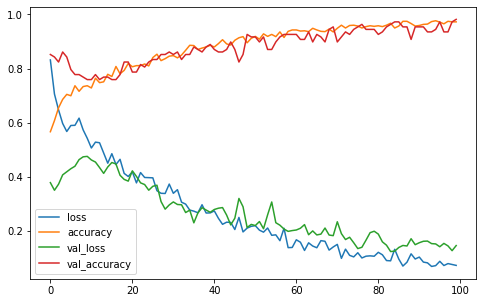

Results for fold 3
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.8610 - accuracy: 0.5885 - val_loss: 0.3873 - val_accuracy: 0.8241
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7940 - accuracy: 0.6163 - val_loss: 0.3759 - val_accuracy: 0.8241
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6287 - accuracy: 0.6615 - val_loss: 0.3799 - val_accuracy: 0.8333
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6764 - accuracy: 0.6646 - val_loss: 0.3995 - val_accuracy: 0.8519
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6358 - accuracy: 0.6749 - val_loss: 0.4124 - val_accuracy: 0.8611
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6116 - accuracy: 0.6934 - val_loss: 0.4079 - val_accuracy: 0.8611
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6249 - accuracy: 0.6800 - val_loss: 0.4268 - val_accuracy: 

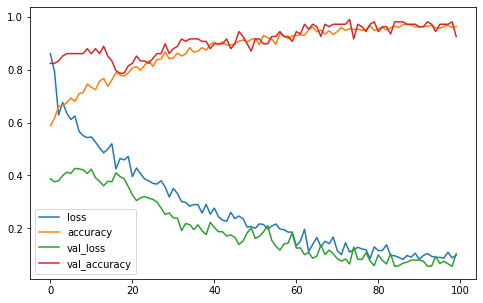

Results for fold 4
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9290 - accuracy: 0.6307 - val_loss: 0.4086 - val_accuracy: 0.8426
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7637 - accuracy: 0.6224 - val_loss: 0.3850 - val_accuracy: 0.8611
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.6512 - val_loss: 0.3953 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6936 - accuracy: 0.6564 - val_loss: 0.4220 - val_accuracy: 0.8333
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6346 - accuracy: 0.6399 - val_loss: 0.4404 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6465 - accuracy: 0.6842 - val_loss: 0.4737 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6366 - accuracy: 0.6862 - val_loss: 0.4984 - val_accuracy: 

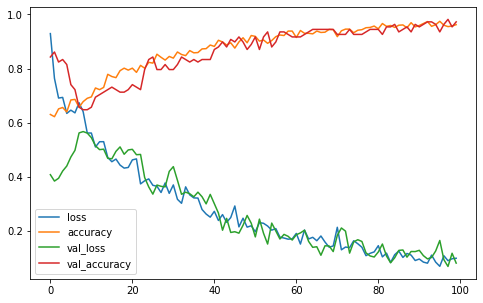

Results for fold 5
Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.9004 - accuracy: 0.5967 - val_loss: 0.5055 - val_accuracy: 0.8148
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6916 - accuracy: 0.6204 - val_loss: 0.5197 - val_accuracy: 0.8611
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6844 - accuracy: 0.6327 - val_loss: 0.5220 - val_accuracy: 0.8333
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6608 - accuracy: 0.6553 - val_loss: 0.5178 - val_accuracy: 0.8056
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6371 - accuracy: 0.6626 - val_loss: 0.5272 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5926 - accuracy: 0.6759 - val_loss: 0.5173 - val_accuracy: 0.7315
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5692 - accuracy: 0.7119 - val_loss: 0.5129 - val_accuracy: 

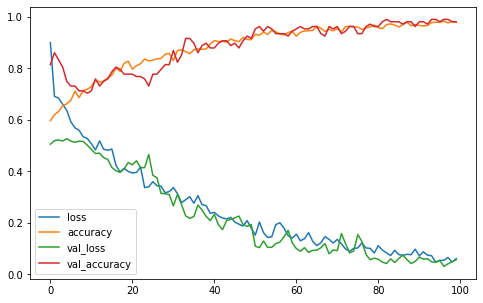

Results for fold 6
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.8088 - accuracy: 0.6019 - val_loss: 0.5608 - val_accuracy: 0.7685
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7056 - accuracy: 0.5895 - val_loss: 0.5276 - val_accuracy: 0.7778
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6750 - accuracy: 0.6245 - val_loss: 0.5173 - val_accuracy: 0.8056
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6612 - accuracy: 0.6471 - val_loss: 0.5223 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6632 - accuracy: 0.6667 - val_loss: 0.5273 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5676 - accuracy: 0.6770 - val_loss: 0.5336 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6071 - accuracy: 0.6790 - val_loss: 0.5381 - val_accuracy: 

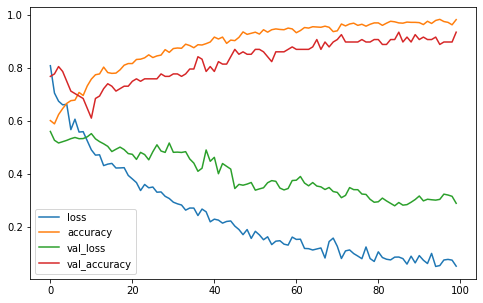

Results for fold 7
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.7781 - accuracy: 0.5504 - val_loss: 0.4046 - val_accuracy: 0.8611
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7302 - accuracy: 0.6379 - val_loss: 0.3577 - val_accuracy: 0.8704
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6451 - accuracy: 0.6142 - val_loss: 0.3465 - val_accuracy: 0.8519
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6390 - accuracy: 0.6626 - val_loss: 0.3483 - val_accuracy: 0.8519
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6127 - accuracy: 0.6512 - val_loss: 0.3656 - val_accuracy: 0.8796
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.6883 - val_loss: 0.3843 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6233 - accuracy: 0.6533 - val_loss: 0.4174 - val_accuracy:

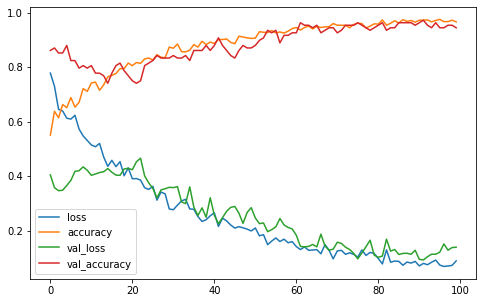

Results for fold 8
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9902 - accuracy: 0.3920 - val_loss: 0.5406 - val_accuracy: 0.7870
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7460 - accuracy: 0.5864 - val_loss: 0.4688 - val_accuracy: 0.7870
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7301 - accuracy: 0.6173 - val_loss: 0.4489 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6554 - accuracy: 0.6533 - val_loss: 0.4386 - val_accuracy: 0.7963
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6590 - accuracy: 0.6842 - val_loss: 0.4393 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5977 - accuracy: 0.6903 - val_loss: 0.4437 - val_accuracy: 0.8519
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5848 - accuracy: 0.6842 - val_loss: 0.4401 - val_accuracy: 

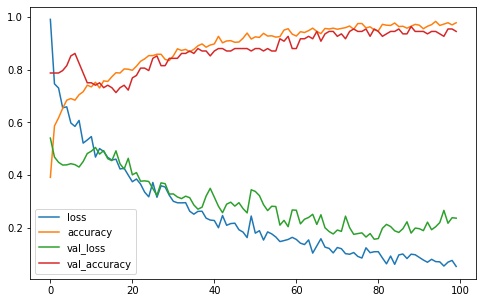

Results for fold 9
Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 0.7747 - accuracy: 0.6502 - val_loss: 0.4323 - val_accuracy: 0.8241
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6625 - accuracy: 0.6348 - val_loss: 0.4141 - val_accuracy: 0.8333
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6665 - accuracy: 0.6677 - val_loss: 0.4357 - val_accuracy: 0.8611
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6308 - accuracy: 0.6934 - val_loss: 0.4663 - val_accuracy: 0.8241
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6278 - accuracy: 0.6893 - val_loss: 0.4825 - val_accuracy: 0.7963
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6079 - accuracy: 0.6944 - val_loss: 0.4858 - val_accuracy: 0.7963
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5496 - accuracy: 0.7047 - val_loss: 0.5142 - val_accuracy: 

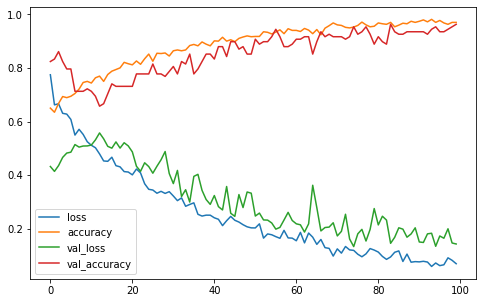

Results for fold 10
Epoch 1/100
16/16 [==============================] - 1s 22ms/step - loss: 0.9279 - accuracy: 0.5689 - val_loss: 0.3804 - val_accuracy: 0.8519
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7464 - accuracy: 0.5802 - val_loss: 0.3580 - val_accuracy: 0.8611
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.7062 - accuracy: 0.6317 - val_loss: 0.3619 - val_accuracy: 0.8611
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6992 - accuracy: 0.6399 - val_loss: 0.3742 - val_accuracy: 0.8889
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6728 - accuracy: 0.6481 - val_loss: 0.4198 - val_accuracy: 0.8889
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.5945 - accuracy: 0.6924 - val_loss: 0.4714 - val_accuracy: 0.8056
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6467 - accuracy: 0.6523 - val_loss: 0.4632 - val_acc

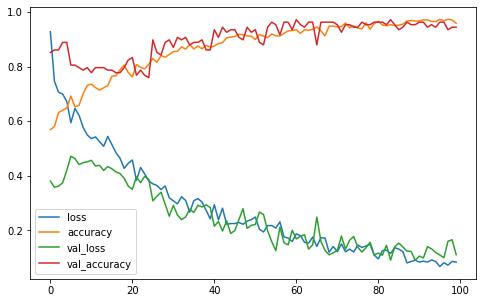

In [50]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9699999988079071
F1_Score  : 0.9489789728495539


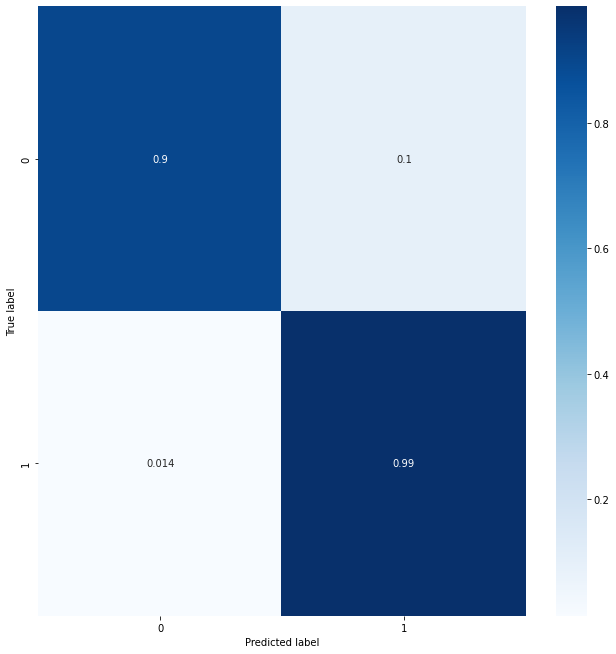

In [51]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()